**CISC 856 - Reinforcement Learning Project**

Group 21:
* Mustafa Shalata
* Mohamed Elsamouly
* Manar AlShabrawy

## **Atari Breakout**

**1. Installing and importing dependecies**

In [ ]:
!pip install gym[atari]
!pip install gym[accept-rom-license]
!pip install keras-rl2
# !pip install gym==0.15.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 20.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=f1fbc6e33e3b9fb1117b89572b251a3359bfccb7bfa763e2428f12178951334b
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.3 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.15.3-py3-none-any.whl size=1644944 sha256=

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import gym
import matplotlib.pyplot as plt

In [ ]:
# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install stable-baselines[mpi]==2.8.0
#Download and install ROMs
!gdown -q http://www.atarimania.com/roms/Roms.rar
!pip install -q unrar
!mkdir ./roms_atari
!unrar x Roms.rar ./roms_atari > /dev/null 2>&1
!python -m atari_py.import_roms ./roms_atari > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.9/222.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.6/540.6 kB 51.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp310-cp310-linux_x86_64.whl size=3365655 sha256=317de7bc1c09979d8125a12c33ff7e6f23903ba4f60e522c2735bcd3ad22afcb
  Stored in directory: /root/.cache/pip/wheels/e8/1b/b5/97ec4cfccdde26e0f3590ad6e09a5242d508dff09704ef86c1
  Created wheel for atari-py: filename=atari_py-0.2.9-cp310-cp310-linux_x86_64.whl size=2856549 sha256=18b4a87221829afaabcc0a1e891647de2bccc0351f21d063cbc1c9826a37e0cb
  Stored in directory: /root/.cache/pip/wheels/75/6f/04/1f3bf5255580101e16ff487564354dddcdd23ec3b43b775b7a
Successfully built mpi4py atari-py


In [ ]:
from stable_baselines.common.atari_wrappers import make_atari, wrap_deepmind
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from google.colab import drive
import gym.wrappers
# Creating a folder in Google Disk
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


(210, 160, 3)


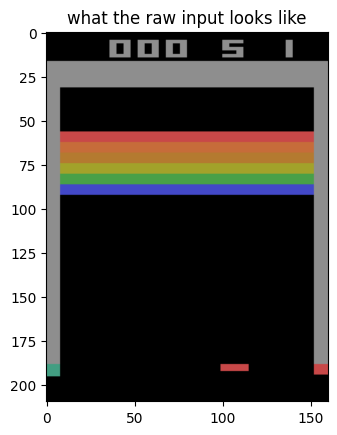

In [ ]:
# Sample Frame
# Observations (raw)
env = gym.make('Breakout-v0')
obs = np.array(env.reset())
print(obs.shape)
plt.title("what the raw input looks like")
plt.imshow(obs)

**2. Examining the Breakout environment**

(84, 84, 4)


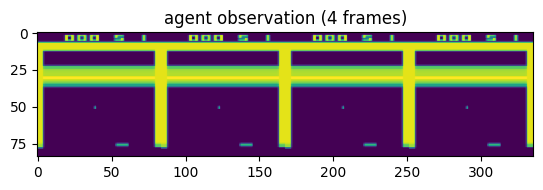

In [ ]:
# State Space
# Obseravtions (wrapped)
env = gym.make('Breakout-v0')
env = wrap_deepmind(env, frame_stack=True, scale=True)
obs = np.array(env.reset())

print(obs.shape)
plt.title("agent observation (4 frames)")
plt.imshow(obs.transpose([0, 2, 1]).reshape([env.observation_space.shape[0], -1]))

* The wrap_deepmind() function preprocesses the image to create a state with shape (84, 84, 4). This state is created by stacking the last 4 preprocessed frames together as shown in Fig2.

In [ ]:
# Actions Space
print(env.action_space)
print(env.get_action_meanings())

Discrete(4)
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


* The action space consists of 4 actions that the agent can take: Left (move left), Right (move right), Fire, and NOOP.

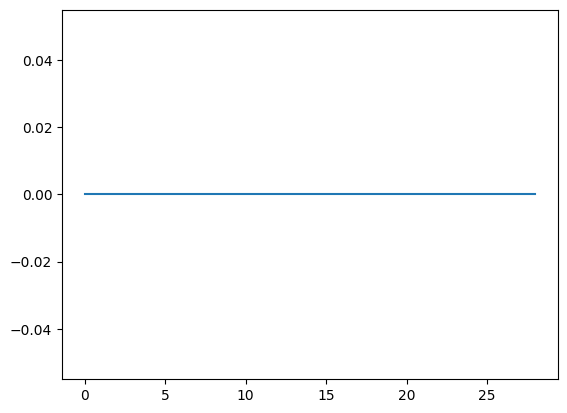

In [ ]:
# Rewards
env.reset()
rewards = []
while True:
    obs, rew, done, info = env.step(env.action_space.sample())
    rewards.append(rew)
    if done:
        break
plt.plot(rewards)

* The agent receives a positive reward of +1 for each brick it hits and a negative reward of -1 for each life it loses. The agent receives 0 reward for all other actions. The episode ends when the agent loses all lives.

**3. Creating a model - Deep convolutional neural network**

In [ ]:
num_actions = 4
def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))

    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

# The first model makes the predictions for Q-values which are used to make a action.
model = create_q_model()
# Target model
model_target = create_q_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 84, 84, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 512)               1606144   
                                                                 
 dense_1 (Dense)             (None, 4)                 2052  

The model consists of five layers:

1. The first layer is a convolutional layer with 32 filters of size 8x8 and stride of 4, using ReLU activation.
2. The second layer is a convolutional layer with 64 filters of size 4x4 and stride of 2, using ReLU activation.
3. The third layer is a convolutional layer with 64 filters of size 3x3 and stride of 1, using ReLU activation.
4. The fourth layer is a flatten layer that flattens the output of the third layer.
5. The fifth layer is a fully connected layer with 512 neurons, using ReLU activation.

The final layer is a fully connected layer with four neurons, representing the four possible actions, using a linear activation function.

#Trial 1

**4.1 Configuring the hyperparamaters and model training**

In [ ]:
# Setting epsilon decay parameters
epsilon = 1.0
epsilon_max_1 = 1.0
epsilon_min_1 = 0.2
epsilon_max_2 = epsilon_min_1
epsilon_min_2 = 0.1
epsilon_max_3 = epsilon_min_2
epsilon_min_3 = 0.02

epsilon_interval_1 = (epsilon_max_1 - epsilon_min_1)
epsilon_interval_2 = (epsilon_max_2 - epsilon_min_2)
epsilon_interval_3 = (epsilon_max_3 - epsilon_min_3)

# Number of frames for exploration
epsilon_greedy_frames = 1000000.0

# Number of frames to take random action and observe output
epsilon_random_frames = 50000

# Maximum Replay Buffer volume
max_memory_length = 190000

# Size of batch taken from replay buffer
batch_size = 32
max_steps_per_episode = 10000

# Train the model after 20 actions
update_after_actions = 20

# How often to update the target network
update_target_network = 10000

# In the Deepmind paper they use RMSProp however then Adam optimizer improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Using huber loss for stability
loss_function = keras.losses.Huber()


In [ ]:
# Loading the model
episode_count = 20000
model_name = f'breakout_model_episode{episode_count}'
path = F"/content/gdrive/MyDrive/models/{model_name}"
model = tf.keras.models.load_model(path)

In [ ]:
model.compile(optimizer="Adam",loss=loss_function)

In [ ]:
model_target.set_weights(model.get_weights())

In [ ]:
# Load the saved model
model = keras.models.load_model('/content/gdrive/MyDrive/models/model_3000.h5')

# Update the target model with the loaded weights
model_target.set_weights(model.get_weights())

In [ ]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from collections import deque

# Create the replay buffer using deque
max_memory_length = 10000
action_history = deque(maxlen=max_memory_length)
state_history = deque(maxlen=max_memory_length)
state_next_history = deque(maxlen=max_memory_length)
rewards_history = deque(maxlen=max_memory_length)
done_history = deque(maxlen=max_memory_length)

# Other parameters
batch_size = 32
gamma = 0.99
update_after_actions = 20
update_target_network = 10000

# Experience replay buffers
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

In [ ]:
# Optimized
cumulative_rewards = []
time_steps = []
test_cumulative_rewards = []
test_time_steps = []

max_test_return = float('-inf')
min_test_time_steps = float('inf')

while True:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            action = np.random.choice(num_actions)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            action = tf.argmax(action_probs[0]).numpy()

        if frame_count < epsilon_greedy_frames:
            epsilon -= epsilon_interval_1 / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min_1)
        elif frame_count < 2 * epsilon_greedy_frames:
            epsilon -= epsilon_interval_2 / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min_2)
        else:
            epsilon -= epsilon_interval_3 / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min_3)

        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward
        cumulative_rewards.append(episode_reward)


        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
            indices = np.random.choice(len(done_history), size=batch_size, replace=False)
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = np.array([rewards_history[i] for i in indices])
            action_sample = np.array([action_history[i] for i in indices])
            done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])

            with tf.GradientTape() as tape:
                future_rewards = model_target(state_next_sample, training=False)
                updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards, axis=1)
                updated_q_values = updated_q_values * (1 - done_sample) - done_sample

                masks = tf.one_hot(action_sample, num_actions)
                q_values = model(state_sample)
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                loss = loss_function(updated_q_values, q_action)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Clear gradients and intermediate variables
            del tape, state_sample, state_next_sample, rewards_sample, action_sample, done_sample

        if frame_count % update_target_network == 0:
            model_target.set_weights(model.get_weights())
            template = "running reward: {:.2f} at episode {}, frame count {}, epsilon {:.3f}, loss {:.5f}"
            print(template.format(running_reward, episode_count, frame_count, epsilon, loss))

        if len(rewards_history) > max_memory_length:
            action_history.popleft()
            state_history.popleft()
            state_next_history.popleft()
            rewards_history.popleft()
            done_history.popleft()

        if done:
            break


    episode_reward_history.append(episode_reward)
    time_steps.append(timestep)

    if len(episode_reward_history) > 100:
        episode_reward_history.pop(0)
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 4:
        print("Solved at episode {}!".format(episode_count))
        break

    if episode_count % 1000 == 0:
        model_name = f'breakout_model_episode{episode_count}'
        path = F"/content/gdrive/MyDrive/models/{model_name}"
        model.save(path)


    # Evaluate the test performance after every 10 episodes of training
    if episode_count % 10 == 0:
        test_rewards = []
        test_episode_reward = 0
        test_episode_time_steps = 0

        for _ in range(5):  # Run 5 test episodes
            state = np.array(env.reset())
            episode_reward = 0

            for _ in range(max_steps_per_episode):
                state_tensor = tf.convert_to_tensor(state)
                state_tensor = tf.expand_dims(state_tensor, 0)
                action_probs = model(state_tensor, training=False)
                action = tf.argmax(action_probs[0]).numpy()

                state, reward, done, _ = env.step(action)
                state = np.array(state)

                episode_reward += reward
                test_episode_reward += reward
                test_episode_time_steps += 1

                if done:
                    break

            test_rewards.append(episode_reward)

        # Calculate the cumulative test reward
        cumulative_test_reward = np.sum(test_rewards)

        test_cumulative_rewards.append(cumulative_test_reward)
        test_time_steps.append(test_episode_time_steps)

        max_test_return = max(max_test_return, cumulative_test_reward)
        min_test_time_steps = min(min_test_time_steps, test_episode_time_steps)

        print("Cumulative Test Reward after episode {}: {:.2f}".format(episode_count, cumulative_test_reward))

Cumulative Test Reward after episode 10: 2.00
Cumulative Test Reward after episode 20: 0.00
Cumulative Test Reward after episode 30: 1.00
Cumulative Test Reward after episode 40: 2.00
Cumulative Test Reward after episode 50: 0.00
Cumulative Test Reward after episode 60: 2.00
Cumulative Test Reward after episode 70: 3.00
Cumulative Test Reward after episode 80: 4.00
Cumulative Test Reward after episode 90: 4.00
Cumulative Test Reward after episode 100: 1.00
Cumulative Test Reward after episode 110: 1.00
Cumulative Test Reward after episode 120: 2.00
Cumulative Test Reward after episode 130: 2.00
Cumulative Test Reward after episode 140: 4.00
Cumulative Test Reward after episode 150: 0.00
Cumulative Test Reward after episode 160: 1.00
Cumulative Test Reward after episode 170: 1.00
Cumulative Test Reward after episode 180: 1.00
Cumulative Test Reward after episode 190: 2.00
running reward: 0.37 at episode 199, frame count 10000, epsilon 0.992, loss 0.01673
Cumulative Test Reward after epi

Cumulative Test Reward after episode 1000: 5.00
Cumulative Test Reward after episode 1010: 0.00
Cumulative Test Reward after episode 1020: 2.00
Cumulative Test Reward after episode 1030: 0.00
Cumulative Test Reward after episode 1040: 4.00
running reward: 0.33 at episode 1045, frame count 50000, epsilon 0.960, loss 0.00549
Cumulative Test Reward after episode 1050: 0.00
Cumulative Test Reward after episode 1060: 5.00
Cumulative Test Reward after episode 1070: 5.00
Cumulative Test Reward after episode 1080: 1.00
Cumulative Test Reward after episode 1090: 0.00
Cumulative Test Reward after episode 1100: 0.00
Cumulative Test Reward after episode 1110: 0.00
Cumulative Test Reward after episode 1120: 2.00
Cumulative Test Reward after episode 1130: 4.00
Cumulative Test Reward after episode 1140: 3.00
Cumulative Test Reward after episode 1150: 1.00
Cumulative Test Reward after episode 1160: 0.00
Cumulative Test Reward after episode 1170: 2.00
Cumulative Test Reward after episode 1180: 1.00
Cum

Cumulative Test Reward after episode 2000: 1.00
Cumulative Test Reward after episode 2010: 2.00
Cumulative Test Reward after episode 2020: 3.00
Cumulative Test Reward after episode 2030: 3.00
Cumulative Test Reward after episode 2040: 0.00
Cumulative Test Reward after episode 2050: 0.00
Cumulative Test Reward after episode 2060: 4.00
Cumulative Test Reward after episode 2070: 3.00
Cumulative Test Reward after episode 2080: 0.00
Cumulative Test Reward after episode 2090: 2.00
Cumulative Test Reward after episode 2100: 2.00
Cumulative Test Reward after episode 2110: 3.00
Cumulative Test Reward after episode 2120: 2.00
Cumulative Test Reward after episode 2130: 2.00
Cumulative Test Reward after episode 2140: 1.00
Cumulative Test Reward after episode 2150: 3.00
Cumulative Test Reward after episode 2160: 1.00
running reward: 0.29 at episode 2163, frame count 100000, epsilon 0.920, loss 0.00376
Cumulative Test Reward after episode 2170: 0.00
Cumulative Test Reward after episode 2180: 1.00
Cu

Cumulative Test Reward after episode 3000: 3.00
Cumulative Test Reward after episode 3010: 3.00
Cumulative Test Reward after episode 3020: 4.00
Cumulative Test Reward after episode 3030: 0.00
Cumulative Test Reward after episode 3040: 1.00
Cumulative Test Reward after episode 3050: 5.00
Cumulative Test Reward after episode 3060: 2.00
Cumulative Test Reward after episode 3070: 3.00
running reward: 0.25 at episode 3073, frame count 140000, epsilon 0.888, loss 0.00683
Cumulative Test Reward after episode 3080: 1.00
Cumulative Test Reward after episode 3090: 2.00
Cumulative Test Reward after episode 3100: 3.00
Cumulative Test Reward after episode 3110: 0.00
Cumulative Test Reward after episode 3120: 4.00
Cumulative Test Reward after episode 3130: 4.00
Cumulative Test Reward after episode 3140: 0.00
Cumulative Test Reward after episode 3150: 1.00
Cumulative Test Reward after episode 3160: 3.00
Cumulative Test Reward after episode 3170: 0.00
Cumulative Test Reward after episode 3180: 4.00
Cu

Cumulative Test Reward after episode 4000: 0.00
Cumulative Test Reward after episode 4010: 2.00
Cumulative Test Reward after episode 4020: 3.00
Cumulative Test Reward after episode 4030: 0.00
Cumulative Test Reward after episode 4040: 4.00
Cumulative Test Reward after episode 4050: 4.00
Cumulative Test Reward after episode 4060: 2.00
Cumulative Test Reward after episode 4070: 3.00
Cumulative Test Reward after episode 4080: 3.00
Cumulative Test Reward after episode 4090: 4.00
Cumulative Test Reward after episode 4100: 0.00
running reward: 0.33 at episode 4109, frame count 190000, epsilon 0.848, loss 0.00360
Cumulative Test Reward after episode 4110: 4.00
Cumulative Test Reward after episode 4120: 0.00
Cumulative Test Reward after episode 4130: 4.00
Cumulative Test Reward after episode 4140: 1.00
Cumulative Test Reward after episode 4150: 0.00
Cumulative Test Reward after episode 4160: 4.00
Cumulative Test Reward after episode 4170: 4.00
Cumulative Test Reward after episode 4180: 4.00
Cu

Cumulative Test Reward after episode 5000: 3.00
Cumulative Test Reward after episode 5010: 2.00
Cumulative Test Reward after episode 5020: 2.00
Cumulative Test Reward after episode 5030: 1.00
Cumulative Test Reward after episode 5040: 3.00
Cumulative Test Reward after episode 5050: 1.00
Cumulative Test Reward after episode 5060: 0.00
Cumulative Test Reward after episode 5070: 1.00
Cumulative Test Reward after episode 5080: 0.00
Cumulative Test Reward after episode 5090: 3.00
Cumulative Test Reward after episode 5100: 1.00
Cumulative Test Reward after episode 5110: 3.00
Cumulative Test Reward after episode 5120: 0.00
Cumulative Test Reward after episode 5130: 2.00
Cumulative Test Reward after episode 5140: 3.00
running reward: 0.30 at episode 5141, frame count 240000, epsilon 0.808, loss 0.00483
Cumulative Test Reward after episode 5150: 3.00
Cumulative Test Reward after episode 5160: 1.00
Cumulative Test Reward after episode 5170: 1.00
Cumulative Test Reward after episode 5180: 3.00
Cu

Cumulative Test Reward after episode 6000: 5.00
Cumulative Test Reward after episode 6010: 2.00
Cumulative Test Reward after episode 6020: 3.00
Cumulative Test Reward after episode 6030: 0.00
Cumulative Test Reward after episode 6040: 1.00
Cumulative Test Reward after episode 6050: 6.00
Cumulative Test Reward after episode 6060: 2.00
Cumulative Test Reward after episode 6070: 4.00
Cumulative Test Reward after episode 6080: 6.00
Cumulative Test Reward after episode 6090: 2.00
running reward: 0.41 at episode 6097, frame count 290000, epsilon 0.768, loss 0.00106
Cumulative Test Reward after episode 6100: 3.00
Cumulative Test Reward after episode 6110: 3.00
Cumulative Test Reward after episode 6120: 4.00
Cumulative Test Reward after episode 6130: 0.00
Cumulative Test Reward after episode 6140: 4.00
Cumulative Test Reward after episode 6150: 5.00
Cumulative Test Reward after episode 6160: 3.00
Cumulative Test Reward after episode 6170: 3.00
Cumulative Test Reward after episode 6180: 0.00
Cu

Cumulative Test Reward after episode 7000: 2.00
Cumulative Test Reward after episode 7010: 5.00
Cumulative Test Reward after episode 7020: 1.00
Cumulative Test Reward after episode 7030: 5.00
running reward: 0.45 at episode 7033, frame count 340000, epsilon 0.728, loss 0.00496
Cumulative Test Reward after episode 7040: 4.00
Cumulative Test Reward after episode 7050: 3.00
Cumulative Test Reward after episode 7060: 4.00
Cumulative Test Reward after episode 7070: 2.00
Cumulative Test Reward after episode 7080: 0.00
Cumulative Test Reward after episode 7090: 1.00
Cumulative Test Reward after episode 7100: 1.00
Cumulative Test Reward after episode 7110: 0.00
Cumulative Test Reward after episode 7120: 2.00
Cumulative Test Reward after episode 7130: 8.00
Cumulative Test Reward after episode 7140: 3.00
Cumulative Test Reward after episode 7150: 6.00
Cumulative Test Reward after episode 7160: 6.00
Cumulative Test Reward after episode 7170: 3.00
Cumulative Test Reward after episode 7180: 4.00
Cu

Cumulative Test Reward after episode 8000: 5.00
Cumulative Test Reward after episode 8010: 0.00
Cumulative Test Reward after episode 8020: 4.00
Cumulative Test Reward after episode 8030: 2.00
Cumulative Test Reward after episode 8040: 7.00
Cumulative Test Reward after episode 8050: 8.00
Cumulative Test Reward after episode 8060: 5.00
Cumulative Test Reward after episode 8070: 6.00
Cumulative Test Reward after episode 8080: 8.00
running reward: 0.72 at episode 8087, frame count 400000, epsilon 0.680, loss 0.01262
Cumulative Test Reward after episode 8090: 5.00
Cumulative Test Reward after episode 8100: 5.00
Cumulative Test Reward after episode 8110: 4.00
Cumulative Test Reward after episode 8120: 5.00
Cumulative Test Reward after episode 8130: 6.00
Cumulative Test Reward after episode 8140: 6.00
Cumulative Test Reward after episode 8150: 11.00
Cumulative Test Reward after episode 8160: 7.00
Cumulative Test Reward after episode 8170: 8.00
Cumulative Test Reward after episode 8180: 7.00
C

Cumulative Test Reward after episode 9000: 15.00
Cumulative Test Reward after episode 9010: 10.00
Cumulative Test Reward after episode 9020: 18.00
Cumulative Test Reward after episode 9030: 7.00
Cumulative Test Reward after episode 9040: 6.00
Cumulative Test Reward after episode 9050: 9.00
Cumulative Test Reward after episode 9060: 7.00
Cumulative Test Reward after episode 9070: 5.00
Cumulative Test Reward after episode 9080: 10.00
Cumulative Test Reward after episode 9090: 14.00
Cumulative Test Reward after episode 9100: 10.00
running reward: 0.93 at episode 9104, frame count 470000, epsilon 0.624, loss 0.00703
Cumulative Test Reward after episode 9110: 8.00
Cumulative Test Reward after episode 9120: 10.00
Cumulative Test Reward after episode 9130: 18.00
Cumulative Test Reward after episode 9140: 14.00
Cumulative Test Reward after episode 9150: 15.00
Cumulative Test Reward after episode 9160: 9.00
Cumulative Test Reward after episode 9170: 8.00
Cumulative Test Reward after episode 918

Cumulative Test Reward after episode 10000: 9.00
Cumulative Test Reward after episode 10010: 9.00
running reward: 1.47 at episode 10019, frame count 550000, epsilon 0.560, loss 0.03405
Cumulative Test Reward after episode 10020: 15.00
Cumulative Test Reward after episode 10030: 13.00
Cumulative Test Reward after episode 10040: 16.00
Cumulative Test Reward after episode 10050: 7.00
Cumulative Test Reward after episode 10060: 7.00
Cumulative Test Reward after episode 10070: 9.00
Cumulative Test Reward after episode 10080: 16.00
Cumulative Test Reward after episode 10090: 8.00
Cumulative Test Reward after episode 10100: 8.00
Cumulative Test Reward after episode 10110: 8.00
running reward: 1.41 at episode 10115, frame count 560000, epsilon 0.552, loss 0.00150
Cumulative Test Reward after episode 10120: 11.00
Cumulative Test Reward after episode 10130: 14.00
Cumulative Test Reward after episode 10140: 17.00
Cumulative Test Reward after episode 10150: 15.00
Cumulative Test Reward after episo

Cumulative Test Reward after episode 11000: 10.00
Cumulative Test Reward after episode 11010: 15.00
running reward: 1.88 at episode 11015, frame count 660000, epsilon 0.472, loss 0.00534
Cumulative Test Reward after episode 11020: 20.00
Cumulative Test Reward after episode 11030: 25.00
Cumulative Test Reward after episode 11040: 18.00
Cumulative Test Reward after episode 11050: 17.00
Cumulative Test Reward after episode 11060: 26.00
Cumulative Test Reward after episode 11070: 21.00
Cumulative Test Reward after episode 11080: 23.00
Cumulative Test Reward after episode 11090: 18.00
Cumulative Test Reward after episode 11100: 15.00
running reward: 1.63 at episode 11106, frame count 670000, epsilon 0.464, loss 0.00250
Cumulative Test Reward after episode 11110: 11.00
Cumulative Test Reward after episode 11120: 19.00
Cumulative Test Reward after episode 11130: 18.00
Cumulative Test Reward after episode 11140: 16.00
Cumulative Test Reward after episode 11150: 24.00
Cumulative Test Reward aft

Cumulative Test Reward after episode 12000: 15.00
Cumulative Test Reward after episode 12010: 12.00
Cumulative Test Reward after episode 12020: 18.00
Cumulative Test Reward after episode 12030: 18.00
Cumulative Test Reward after episode 12040: 17.00
Cumulative Test Reward after episode 12050: 8.00
Cumulative Test Reward after episode 12060: 14.00
running reward: 2.30 at episode 12063, frame count 790000, epsilon 0.368, loss 0.00685
Cumulative Test Reward after episode 12070: 12.00
Cumulative Test Reward after episode 12080: 19.00
Cumulative Test Reward after episode 12090: 20.00
Cumulative Test Reward after episode 12100: 15.00
Cumulative Test Reward after episode 12110: 18.00
Cumulative Test Reward after episode 12120: 22.00
Cumulative Test Reward after episode 12130: 16.00
Cumulative Test Reward after episode 12140: 27.00
running reward: 2.13 at episode 12140, frame count 800000, epsilon 0.360, loss 0.00517
Cumulative Test Reward after episode 12150: 16.00
Cumulative Test Reward afte

Cumulative Test Reward after episode 13000: 24.00
Cumulative Test Reward after episode 13010: 20.00
Cumulative Test Reward after episode 13020: 20.00
Cumulative Test Reward after episode 13030: 16.00
running reward: 2.58 at episode 13030, frame count 930000, epsilon 0.256, loss 0.00189
Cumulative Test Reward after episode 13040: 30.00
Cumulative Test Reward after episode 13050: 25.00
Cumulative Test Reward after episode 13060: 32.00
Cumulative Test Reward after episode 13070: 40.00
Cumulative Test Reward after episode 13080: 12.00
running reward: 2.97 at episode 13089, frame count 940000, epsilon 0.248, loss 0.01913
Cumulative Test Reward after episode 13090: 11.00
Cumulative Test Reward after episode 13100: 11.00
Cumulative Test Reward after episode 13110: 36.00
Cumulative Test Reward after episode 13120: 33.00
Cumulative Test Reward after episode 13130: 29.00
running reward: 3.24 at episode 13138, frame count 950000, epsilon 0.240, loss 0.00247
Cumulative Test Reward after episode 13

**Observations:**

* The results show that the deep Q-learning algorithm is successfully training an agent to play the Breakout game. The running reward, which measures the average score the agent receives per episode, increases steadily over time, going from 0.37 at episode 199 to 3.68 at episode 13337, with the game being solved at episode 13380.

* The frame count, which measures the number of game frames that the agent has processed, increases gradually over time, reaching 990,000 frames by episode 13337.

* The epsilon value, which determines the exploration rate of the agent, decreases over time, indicating that the agent is relying more on its learned policy and less on exploration. The epsilon value decreases from 0. 992 at episode 9104 to 0.208 at episode 13291.

* The loss value, which measures the error of the neural network model used in the algorithm, fluctuates over time but generally remains low, indicating that the model is learning well. The loss value reaches a minimum of 0.00136 at episode 13241.

Overall, the results show that the deep Q-learning algorithm is effective at training an agent to play the Breakout game, and the agent's performance steadily improves over time. The agent's ability to solve the game at episode 13380 demonstrates the success of the algorithm in teaching the agent to play the game at a high level.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


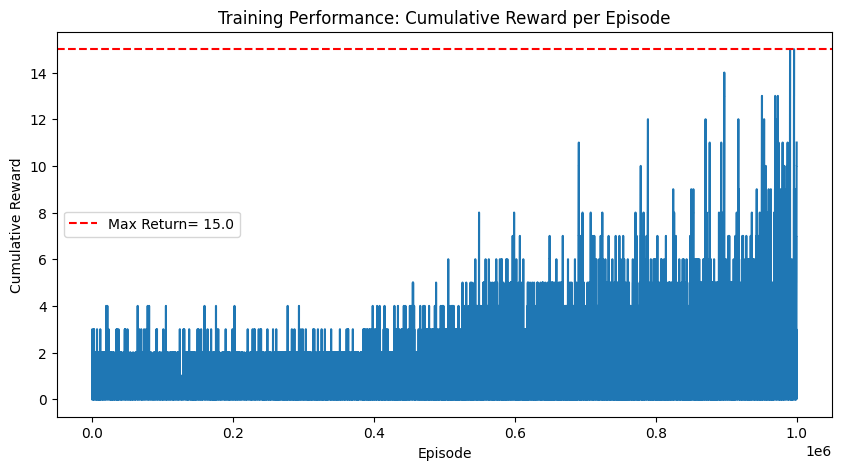

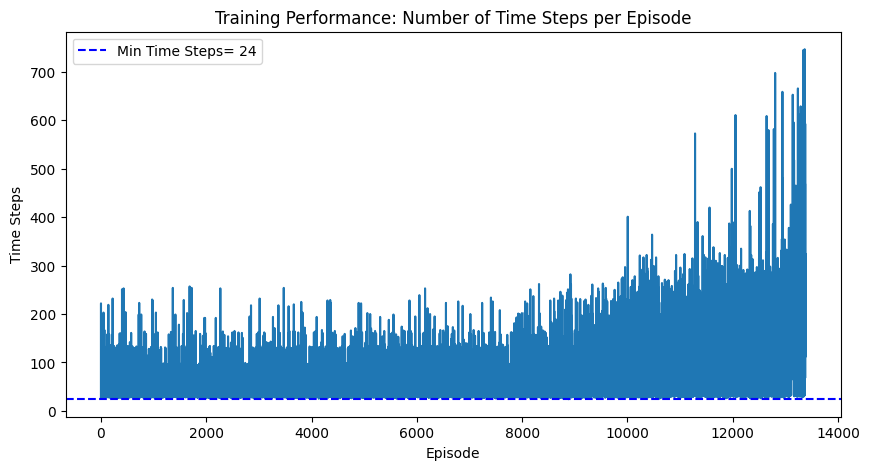

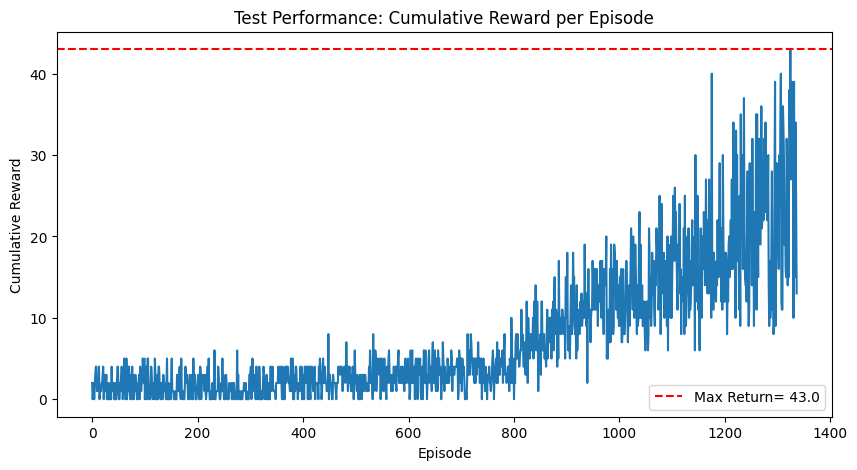

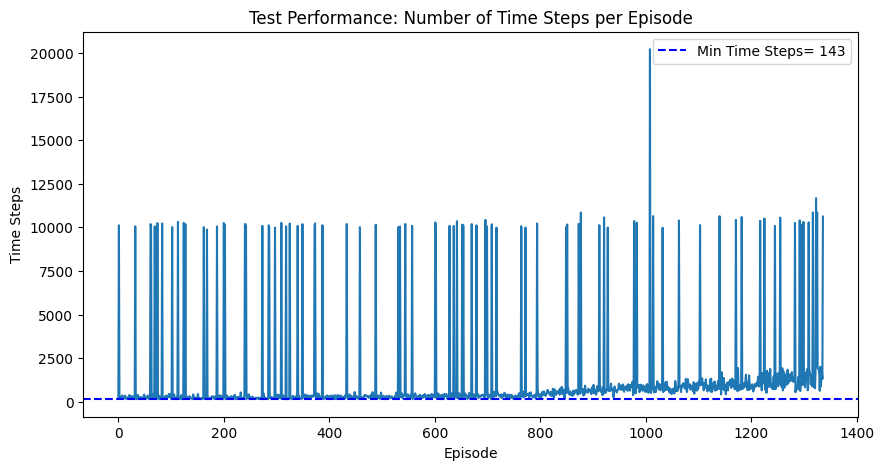

In [ ]:
# Plot cumulative reward per episode for training
plt.figure(figsize=(10, 5))
plt.plot(cumulative_rewards)
# plt.axvline(x=np.argmin(cumulative_rewards), color='r', linestyle='--', label='Optimal Episode')
plt.axhline(y=max(cumulative_rewards), color='r', linestyle='--', label=f'Max Return= {max(cumulative_rewards)}')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Training Performance: Cumulative Reward per Episode')
plt.legend()
plt.show()

# Plot number of time steps required per episode for training
plt.figure(figsize=(10, 5))
plt.plot(time_steps)
# plt.axvline(x=np.argmin(time_steps), color='r', linestyle='--', label='Optimal Episode')
plt.axhline(y=min(time_steps), color='b', linestyle='--', label=f'Min Time Steps= {min(time_steps)}')
plt.xlabel('Episode')
plt.ylabel('Time Steps')
plt.title('Training Performance: Number of Time Steps per Episode')
plt.legend()
plt.show()


# Plot cumulative reward per episode for test
plt.figure(figsize=(10, 5))
plt.plot(test_cumulative_rewards)
# plt.axvline(x=np.argmin(max_test_return), color='r', linestyle='--', label='Optimal Episode')
plt.axhline(y=max_test_return, color='r', linestyle='--', label=f'Max Return= {max_test_return}')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Test Performance: Cumulative Reward per Episode')
plt.legend()
plt.show()

# Plot number of time steps required per episode for test
plt.figure(figsize=(10, 5))
plt.plot(test_time_steps)
# plt.axvline(x=np.argmin(min_test_time_steps), color='r', linestyle='--', label='Optimal Episode')
plt.axhline(y=min_test_time_steps, color='b', linestyle='--', label=f'Min Time Steps= {min_test_time_steps}')
plt.xlabel('Episode')
plt.ylabel('Time Steps')
plt.title('Test Performance: Number of Time Steps per Episode')
plt.legend()
plt.show()

**Obseravtions:**

* Training Performance:
  * Maximum return: 15.0
  * Minimum number of time-steps: 24

* Test Performance:
  * Maximum return: 43.0
  * Minimum number of time-steps: 143

**5.1 Save and load the model**

In [ ]:
 # #Saving the model
# model_name = 'breakout_model_10'
# path = F"/content/gdrive/MyDrive/models/{model_name}"
# model.save(path)

# Loading the model
# model = tf.keras.models.load_model(path)

model_name = 'breakout_model_10'
path = F"/content/gdrive/MyDrive/models/{model_name}"
model = tf.keras.models.load_model(path)

**6.1 Making videos of our agent play**

In [ ]:
def make_env():
  env = make_atari("BreakoutNoFrameskip-v4")
  env = wrap_deepmind(env, frame_stack=True, scale=True)
  return env

In [ ]:
# !pip install gym==0.15.3

Lost one life after 187 timesteps
{'ale.lives': 4}


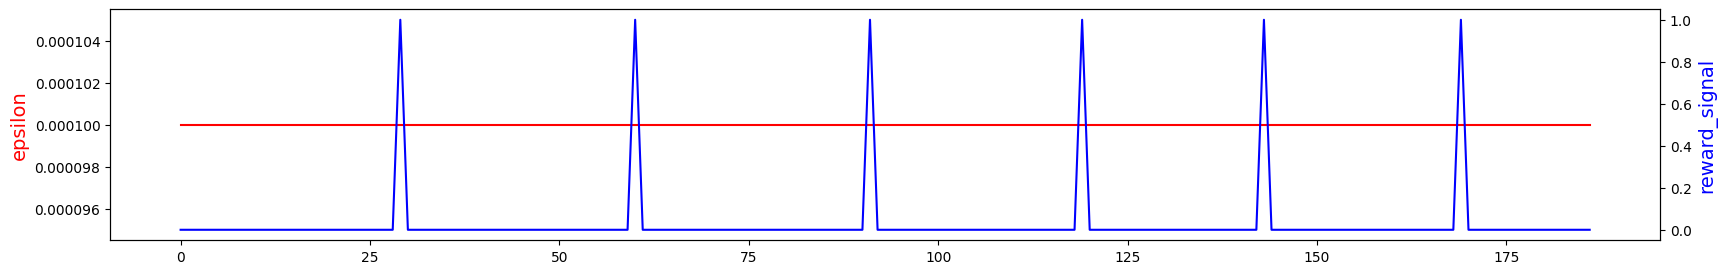

Bricks left to destroy  102.0
Lost one life after 306 timesteps
{'ale.lives': 3}


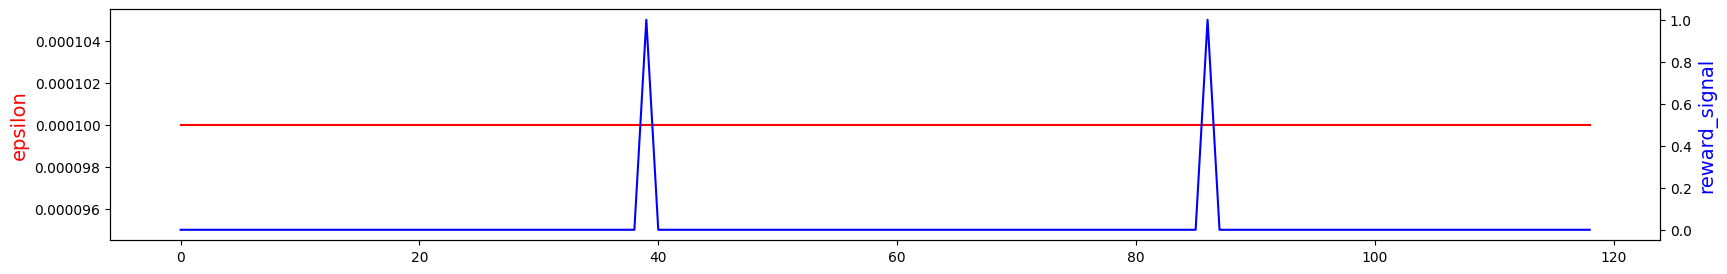

Bricks left to destroy  100.0
Lost one life after 489 timesteps
{'ale.lives': 2}


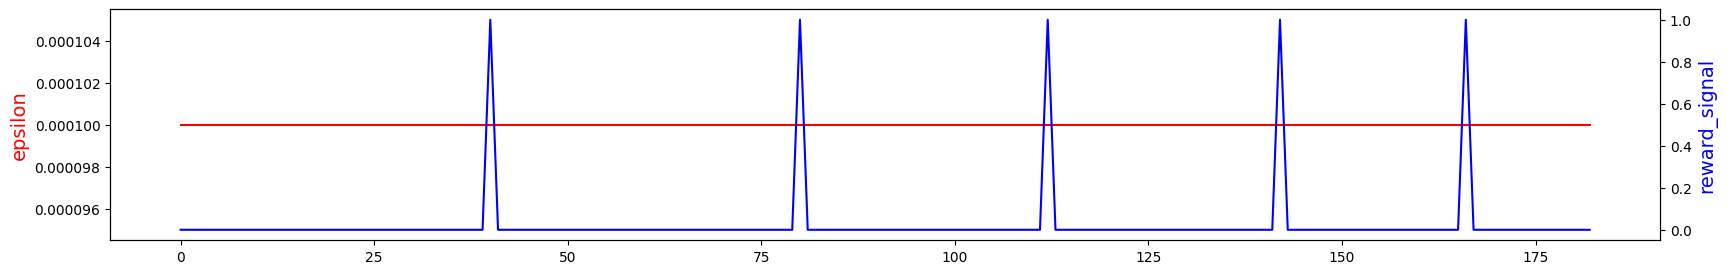

Bricks left to destroy  95.0
Lost one life after 846 timesteps
{'ale.lives': 1}


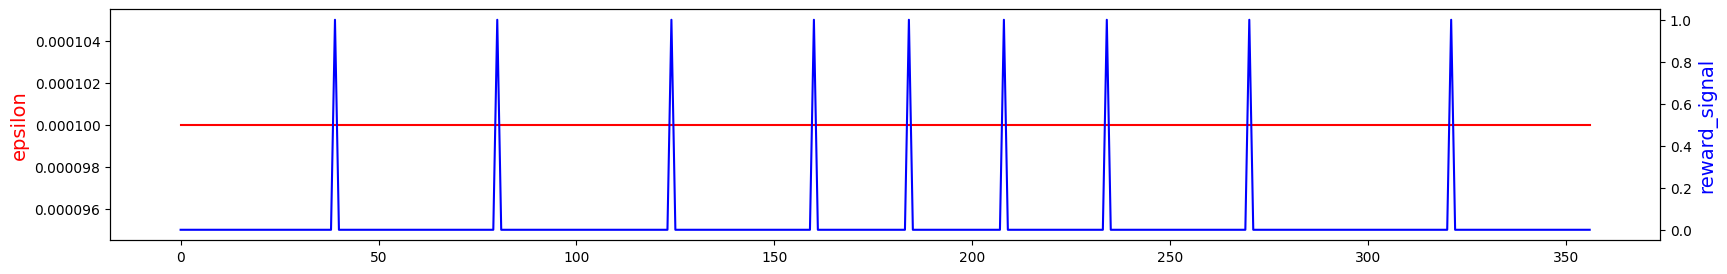

Bricks left to destroy  86.0
Lost one life after 1063 timesteps
{'ale.lives': 0}


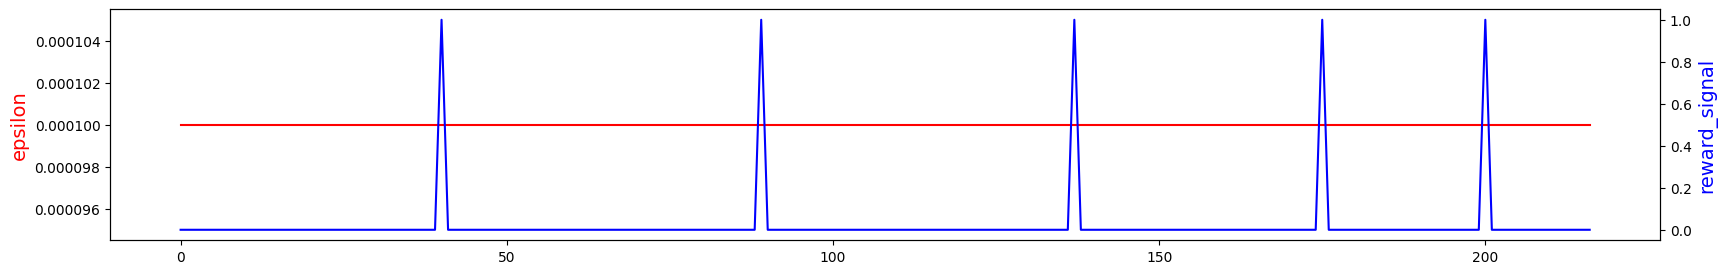

Bricks left to destroy  81.0


In [ ]:
env = make_env()
env = gym.wrappers.Monitor(env, "./vid1", force=True)

observation = env.reset()
info = 0
reward_window = []
reward_signal_history = []
epsilon_history = []

hits = []
bltd = 108 #total bricks to destroy

for i_episode in range(1):
    reward_window=[]
    epsilon = 0
    for t in range(4000):

        if epsilon > np.random.rand(1)[0]:
          action = np.random.choice(num_actions)
        else:
          state_tensor = tf.convert_to_tensor(observation)
          state_tensor = tf.expand_dims(state_tensor, 0)
          action_probs = model(state_tensor, training=False)
          action = tf.argmax(action_probs[0]).numpy()

        observation, reward, done, info = env.step(action)
        hits.append(reward)
        reward_window.append(reward)
        if len(reward_window) > 200:
          del reward_window[:1]
        if len(reward_window) == 200 and np.sum(reward_window) == 0:
          epsilon = 0.01
        else:
          epsilon = 0.0001

        epsilon_history.append(epsilon)
        reward_signal_history.append(reward)


        if done:
            print("Lost one life after {} timesteps".format(t+1))
            print(info)
            # Plot epsilon and reward signal
            fig,ax=plt.subplots(figsize=(20,3))
            #plt.clf()
            ax.plot(epsilon_history, color="red")
            ax.set_ylabel("epsilon",color="red",fontsize=14)
            ax2=ax.twinx()
            ax2.plot(reward_signal_history,color="blue")
            ax2.set_ylabel("reward_signal",color="blue",fontsize=14)
            plt.show()

            epsilon_history = []
            reward_signal_history = []

            bltd = bltd-np.sum(hits)
            hits = []
            print("Bricks left to destroy ", bltd)
            if info['ale.lives'] == 0:
              break

            env.reset()
env.close()

#Trial 2

In this trail, we focused on tring different hyper parameters in order to find out the effect on the model performance and tring to improve it.

**4.2 Configuring the hyperparamaters and model training**

In [ ]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from collections import deque

In [ ]:
# Setting epsilon decay parameters
epsilon = 1.0
epsilon_max_1 = 1.0
epsilon_min_1 = 0.1  # Modified: Decreased epsilon_min_1 for more exploration
epsilon_max_2 = epsilon_min_1
epsilon_min_2 = 0.05  # Modified: Decreased epsilon_min_2 for more exploration
epsilon_max_3 = epsilon_min_2
epsilon_min_3 = 0.01  # Modified: Decreased epsilon_min_3 for more exploration

epsilon_interval_1 = (epsilon_max_1 - epsilon_min_1)
epsilon_interval_2 = (epsilon_max_2 - epsilon_min_2)
epsilon_interval_3 = (epsilon_max_3 - epsilon_min_3)

# Number of frames for exploration
epsilon_greedy_frames = 1000000.0

# Number of frames to take random action and observe output
epsilon_random_frames = 50000

# Maximum Replay Buffer volume
max_memory_length = 190000

# Size of batch taken from replay buffer
batch_size = 64  # Modified: Increased batch size for faster convergence
max_steps_per_episode = 10000

# Train the model after 20 actions
update_after_actions = 10  # Modified: Decreased update_after_actions for more frequent updates

# How often to update the target network
update_target_network = 5000  # Modified: Decreased update_target_network for more frequent updates

# In the Deepmind paper they use RMSProp however then Adam optimizer improves training time
optimizer = Adam(learning_rate=0.00025, clipnorm=1.0)

# Using huber loss for stability
loss_function = Huber()

In [ ]:
# Create the replay buffer using deque
max_memory_length = 10000
action_history = deque(maxlen=max_memory_length)
state_history = deque(maxlen=max_memory_length)
state_next_history = deque(maxlen=max_memory_length)
rewards_history = deque(maxlen=max_memory_length)
done_history = deque(maxlen=max_memory_length)

# Other parameters
batch_size = 64
gamma = 0.99
update_after_actions = 10
update_target_network = 5000

# Experience replay buffers
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

* The modifications includes the following:
 1. Decreasing the epsilon_min values to encourage more exploration
 2. Increasing the batch size for faster convergence
 3. Decreasing the update_after_actions and update_target_network values for more frequent updates.

These changes should help improve the learning process and potentially lead to better results in your trial.

In [ ]:
# Optimized
cumulative_rewards = []
time_steps = []
test_cumulative_rewards = []
test_time_steps = []

max_test_return = float('-inf')
min_test_time_steps = float('inf')

while True:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            action = np.random.choice(num_actions)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            action = tf.argmax(action_probs[0]).numpy()

        if frame_count < epsilon_greedy_frames:
            epsilon -= epsilon_interval_1 / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min_1)
        elif frame_count < 2 * epsilon_greedy_frames:
            epsilon -= epsilon_interval_2 / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min_2)
        else:
            epsilon -= epsilon_interval_3 / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min_3)

        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward
        cumulative_rewards.append(episode_reward)


        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
            indices = np.random.choice(len(done_history), size=batch_size, replace=False)
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = np.array([rewards_history[i] for i in indices])
            action_sample = np.array([action_history[i] for i in indices])
            done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])

            with tf.GradientTape() as tape:
                future_rewards = model_target(state_next_sample, training=False)
                updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards, axis=1)
                updated_q_values = updated_q_values * (1 - done_sample) - done_sample

                masks = tf.one_hot(action_sample, num_actions)
                q_values = model(state_sample)
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                loss = loss_function(updated_q_values, q_action)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Clear gradients and intermediate variables
            del tape, state_sample, state_next_sample, rewards_sample, action_sample, done_sample

        if frame_count % update_target_network == 0:
            model_target.set_weights(model.get_weights())
            template = "running reward: {:.2f} at episode {}, frame count {}, epsilon {:.3f}, loss {:.5f}"
            print(template.format(running_reward, episode_count, frame_count, epsilon, loss))

        if len(rewards_history) > max_memory_length:
            action_history.popleft()
            state_history.popleft()
            state_next_history.popleft()
            rewards_history.popleft()
            done_history.popleft()

        if done:
            break


    episode_reward_history.append(episode_reward)
    time_steps.append(timestep)

    if len(episode_reward_history) > 100:
        episode_reward_history.pop(0)
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 4:
        print("Solved at episode {}!".format(episode_count))
        break

    if episode_count % 1000 == 0:
        model_name = f'breakout_model_episode{episode_count}_trial_2'
        path = F"/content/gdrive/MyDrive/models/{model_name}"
        model.save(path)


    # Evaluate the test performance after every 10 episodes of training
    if episode_count % 10 == 0:
        test_rewards = []
        test_episode_reward = 0
        test_episode_time_steps = 0

        for _ in range(5):  # Run 5 test episodes
            state = np.array(env.reset())
            episode_reward = 0

            for _ in range(max_steps_per_episode):
                state_tensor = tf.convert_to_tensor(state)
                state_tensor = tf.expand_dims(state_tensor, 0)
                action_probs = model(state_tensor, training=False)
                action = tf.argmax(action_probs[0]).numpy()

                state, reward, done, _ = env.step(action)
                state = np.array(state)

                episode_reward += reward
                test_episode_reward += reward
                test_episode_time_steps += 1

                if done:
                    break

            test_rewards.append(episode_reward)

        # Calculate the cumulative test reward
        cumulative_test_reward = np.sum(test_rewards)

        test_cumulative_rewards.append(cumulative_test_reward)
        test_time_steps.append(test_episode_time_steps)

        max_test_return = max(max_test_return, cumulative_test_reward)
        min_test_time_steps = min(min_test_time_steps, test_episode_time_steps)

        print("Cumulative Test Reward after episode {}: {:.2f}".format(episode_count, cumulative_test_reward))

Cumulative Test Reward after episode 10: 3.00
Cumulative Test Reward after episode 20: 2.00
Cumulative Test Reward after episode 30: 2.00
Cumulative Test Reward after episode 40: 0.00
Cumulative Test Reward after episode 50: 2.00
Cumulative Test Reward after episode 60: 1.00
Cumulative Test Reward after episode 70: 2.00
Cumulative Test Reward after episode 80: 3.00
Cumulative Test Reward after episode 90: 3.00
Cumulative Test Reward after episode 100: 3.00
running reward: 0.29 at episode 105, frame count 5000, epsilon 0.996, loss 0.00090
Cumulative Test Reward after episode 110: 3.00
Cumulative Test Reward after episode 120: 0.00
Cumulative Test Reward after episode 130: 2.00
Cumulative Test Reward after episode 140: 0.00
Cumulative Test Reward after episode 150: 0.00
Cumulative Test Reward after episode 160: 0.00
Cumulative Test Reward after episode 170: 1.00
Cumulative Test Reward after episode 180: 0.00
Cumulative Test Reward after episode 190: 3.00
Cumulative Test Reward after epis

Cumulative Test Reward after episode 1000: 0.00
Cumulative Test Reward after episode 1010: 3.00
Cumulative Test Reward after episode 1020: 3.00
Cumulative Test Reward after episode 1030: 3.00
Cumulative Test Reward after episode 1040: 2.00
Cumulative Test Reward after episode 1050: 3.00
Cumulative Test Reward after episode 1060: 0.00
Cumulative Test Reward after episode 1070: 1.00
running reward: 0.16 at episode 1075, frame count 50000, epsilon 0.955, loss 0.00188
Cumulative Test Reward after episode 1080: 2.00
Cumulative Test Reward after episode 1090: 3.00
Cumulative Test Reward after episode 1100: 1.00
Cumulative Test Reward after episode 1110: 0.00
Cumulative Test Reward after episode 1120: 1.00
Cumulative Test Reward after episode 1130: 3.00
Cumulative Test Reward after episode 1140: 0.00
Cumulative Test Reward after episode 1150: 0.00
Cumulative Test Reward after episode 1160: 0.00
Cumulative Test Reward after episode 1170: 3.00
Cumulative Test Reward after episode 1180: 0.00
run

Cumulative Test Reward after episode 2000: 1.00
Cumulative Test Reward after episode 2010: 2.00
Cumulative Test Reward after episode 2020: 2.00
Cumulative Test Reward after episode 2030: 2.00
Cumulative Test Reward after episode 2040: 0.00
Cumulative Test Reward after episode 2050: 5.00
Cumulative Test Reward after episode 2060: 2.00
running reward: 0.29 at episode 2068, frame count 95000, epsilon 0.915, loss 0.00174
Cumulative Test Reward after episode 2070: 1.00
Cumulative Test Reward after episode 2080: 1.00
Cumulative Test Reward after episode 2090: 0.00
Cumulative Test Reward after episode 2100: 3.00
Cumulative Test Reward after episode 2110: 1.00
Cumulative Test Reward after episode 2120: 5.00
Cumulative Test Reward after episode 2130: 1.00
Cumulative Test Reward after episode 2140: 0.00
Cumulative Test Reward after episode 2150: 4.00
Cumulative Test Reward after episode 2160: 3.00
Cumulative Test Reward after episode 2170: 0.00
Cumulative Test Reward after episode 2180: 5.00
run

Cumulative Test Reward after episode 3000: 3.00
Cumulative Test Reward after episode 3010: 3.00
Cumulative Test Reward after episode 3020: 2.00
Cumulative Test Reward after episode 3030: 1.00
Cumulative Test Reward after episode 3040: 1.00
Cumulative Test Reward after episode 3050: 0.00
Cumulative Test Reward after episode 3060: 3.00
Cumulative Test Reward after episode 3070: 2.00
Cumulative Test Reward after episode 3080: 7.00
Cumulative Test Reward after episode 3090: 4.00
running reward: 0.29 at episode 3091, frame count 140000, epsilon 0.874, loss 0.00506
Cumulative Test Reward after episode 3100: 3.00
Cumulative Test Reward after episode 3110: 1.00
Cumulative Test Reward after episode 3120: 3.00
Cumulative Test Reward after episode 3130: 3.00
Cumulative Test Reward after episode 3140: 0.00
Cumulative Test Reward after episode 3150: 1.00
Cumulative Test Reward after episode 3160: 2.00
Cumulative Test Reward after episode 3170: 2.00
Cumulative Test Reward after episode 3180: 4.00
Cu

Cumulative Test Reward after episode 4000: 4.00
Cumulative Test Reward after episode 4010: 5.00
Cumulative Test Reward after episode 4020: 3.00
Cumulative Test Reward after episode 4030: 5.00
Cumulative Test Reward after episode 4040: 5.00
Cumulative Test Reward after episode 4050: 5.00
running reward: 0.32 at episode 4058, frame count 185000, epsilon 0.834, loss 0.00474
Cumulative Test Reward after episode 4060: 4.00
Cumulative Test Reward after episode 4070: 5.00
Cumulative Test Reward after episode 4080: 10.00
Cumulative Test Reward after episode 4090: 2.00
Cumulative Test Reward after episode 4100: 3.00
Cumulative Test Reward after episode 4110: 3.00
Cumulative Test Reward after episode 4120: 3.00
Cumulative Test Reward after episode 4130: 4.00
Cumulative Test Reward after episode 4140: 4.00
Cumulative Test Reward after episode 4150: 4.00
running reward: 0.36 at episode 4156, frame count 190000, epsilon 0.829, loss 0.00977
Cumulative Test Reward after episode 4160: 4.00
Cumulative 

Cumulative Test Reward after episode 5000: 5.00
Cumulative Test Reward after episode 5010: 8.00
Cumulative Test Reward after episode 5020: 9.00
running reward: 0.58 at episode 5027, frame count 240000, epsilon 0.784, loss 0.00895
Cumulative Test Reward after episode 5030: 3.00
Cumulative Test Reward after episode 5040: 5.00
Cumulative Test Reward after episode 5050: 6.00
Cumulative Test Reward after episode 5060: 10.00
Cumulative Test Reward after episode 5070: 5.00
Cumulative Test Reward after episode 5080: 6.00
Cumulative Test Reward after episode 5090: 7.00
Cumulative Test Reward after episode 5100: 5.00
running reward: 0.62 at episode 5104, frame count 245000, epsilon 0.780, loss 0.01281
Cumulative Test Reward after episode 5110: 3.00
Cumulative Test Reward after episode 5120: 7.00
Cumulative Test Reward after episode 5130: 9.00
Cumulative Test Reward after episode 5140: 6.00
Cumulative Test Reward after episode 5150: 7.00
Cumulative Test Reward after episode 5160: 5.00
Cumulative 

Cumulative Test Reward after episode 6000: 8.00
Cumulative Test Reward after episode 6010: 9.00
Cumulative Test Reward after episode 6020: 7.00
Cumulative Test Reward after episode 6030: 7.00
running reward: 0.80 at episode 6033, frame count 305000, epsilon 0.726, loss 0.01537
Cumulative Test Reward after episode 6040: 10.00
Cumulative Test Reward after episode 6050: 6.00
Cumulative Test Reward after episode 6060: 14.00
Cumulative Test Reward after episode 6070: 6.00
Cumulative Test Reward after episode 6080: 9.00
Cumulative Test Reward after episode 6090: 10.00
Cumulative Test Reward after episode 6100: 2.00
Cumulative Test Reward after episode 6110: 12.00
running reward: 0.49 at episode 6118, frame count 310000, epsilon 0.721, loss 0.01004
Cumulative Test Reward after episode 6120: 8.00
Cumulative Test Reward after episode 6130: 4.00
Cumulative Test Reward after episode 6140: 9.00
Cumulative Test Reward after episode 6150: 11.00
Cumulative Test Reward after episode 6160: 5.00
Cumulat

Cumulative Test Reward after episode 7000: 11.00
Cumulative Test Reward after episode 7010: 11.00
Cumulative Test Reward after episode 7020: 9.00
Cumulative Test Reward after episode 7030: 8.00
Cumulative Test Reward after episode 7040: 16.00
Cumulative Test Reward after episode 7050: 7.00
Cumulative Test Reward after episode 7060: 12.00
running reward: 0.77 at episode 7061, frame count 375000, epsilon 0.663, loss 0.00637
Cumulative Test Reward after episode 7070: 12.00
Cumulative Test Reward after episode 7080: 14.00
Cumulative Test Reward after episode 7090: 8.00
Cumulative Test Reward after episode 7100: 8.00
Cumulative Test Reward after episode 7110: 9.00
Cumulative Test Reward after episode 7120: 11.00
Cumulative Test Reward after episode 7130: 6.00
running reward: 0.68 at episode 7136, frame count 380000, epsilon 0.658, loss 0.01108
Cumulative Test Reward after episode 7140: 14.00
Cumulative Test Reward after episode 7150: 8.00
Cumulative Test Reward after episode 7160: 11.00
Cum

Cumulative Test Reward after episode 8000: 13.00
Cumulative Test Reward after episode 8010: 10.00
Cumulative Test Reward after episode 8020: 3.00
running reward: 0.98 at episode 8020, frame count 450000, epsilon 0.595, loss 0.00663
Cumulative Test Reward after episode 8030: 9.00
Cumulative Test Reward after episode 8040: 9.00
Cumulative Test Reward after episode 8050: 6.00
Cumulative Test Reward after episode 8060: 19.00
Cumulative Test Reward after episode 8070: 9.00
Cumulative Test Reward after episode 8080: 7.00
running reward: 1.00 at episode 8081, frame count 455000, epsilon 0.591, loss 0.00817
Cumulative Test Reward after episode 8090: 13.00
Cumulative Test Reward after episode 8100: 12.00
Cumulative Test Reward after episode 8110: 10.00
Cumulative Test Reward after episode 8120: 18.00
Cumulative Test Reward after episode 8130: 13.00
running reward: 1.12 at episode 8135, frame count 460000, epsilon 0.586, loss 0.04021
Cumulative Test Reward after episode 8140: 7.00
Cumulative Tes

running reward: 1.60 at episode 8999, frame count 535000, epsilon 0.519, loss 0.01785


Cumulative Test Reward after episode 9000: 17.00
Cumulative Test Reward after episode 9010: 24.00
Cumulative Test Reward after episode 9020: 15.00
Cumulative Test Reward after episode 9030: 13.00
Cumulative Test Reward after episode 9040: 10.00
Cumulative Test Reward after episode 9050: 13.00
running reward: 1.43 at episode 9058, frame count 540000, epsilon 0.514, loss 0.02261
Cumulative Test Reward after episode 9060: 13.00
Cumulative Test Reward after episode 9070: 16.00
Cumulative Test Reward after episode 9080: 10.00
Cumulative Test Reward after episode 9090: 13.00
Cumulative Test Reward after episode 9100: 13.00
Cumulative Test Reward after episode 9110: 16.00
running reward: 1.10 at episode 9112, frame count 545000, epsilon 0.510, loss 0.00612
Cumulative Test Reward after episode 9120: 6.00
Cumulative Test Reward after episode 9130: 8.00
Cumulative Test Reward after episode 9140: 13.00
Cumulative Test Reward after episode 9150: 15.00
Cumulative Test Reward after episode 9160: 12.

Cumulative Test Reward after episode 10000: 21.00
Cumulative Test Reward after episode 10010: 28.00
Cumulative Test Reward after episode 10020: 22.00
Cumulative Test Reward after episode 10030: 14.00
Cumulative Test Reward after episode 10040: 13.00
running reward: 1.52 at episode 10041, frame count 640000, epsilon 0.424, loss 0.00254
Cumulative Test Reward after episode 10050: 12.00
Cumulative Test Reward after episode 10060: 8.00
Cumulative Test Reward after episode 10070: 13.00
running reward: 1.62 at episode 10079, frame count 645000, epsilon 0.420, loss 0.00332
Cumulative Test Reward after episode 10080: 12.00
Cumulative Test Reward after episode 10090: 17.00
Cumulative Test Reward after episode 10100: 15.00
Cumulative Test Reward after episode 10110: 11.00
running reward: 1.88 at episode 10118, frame count 650000, epsilon 0.415, loss 0.00527
Cumulative Test Reward after episode 10120: 15.00
Cumulative Test Reward after episode 10130: 18.00
Cumulative Test Reward after episode 101

Cumulative Test Reward after episode 11000: 12.00
Cumulative Test Reward after episode 11010: 8.00
Cumulative Test Reward after episode 11020: 14.00
running reward: 2.31 at episode 11028, frame count 765000, epsilon 0.312, loss 0.00936
Cumulative Test Reward after episode 11030: 17.00
Cumulative Test Reward after episode 11040: 25.00
Cumulative Test Reward after episode 11050: 24.00
running reward: 2.49 at episode 11056, frame count 770000, epsilon 0.307, loss 0.00449
Cumulative Test Reward after episode 11060: 34.00
Cumulative Test Reward after episode 11070: 14.00
Cumulative Test Reward after episode 11080: 13.00
Cumulative Test Reward after episode 11090: 9.00
running reward: 2.65 at episode 11090, frame count 775000, epsilon 0.303, loss 0.00538
Cumulative Test Reward after episode 11100: 15.00
Cumulative Test Reward after episode 11110: 16.00
Cumulative Test Reward after episode 11120: 15.00
Cumulative Test Reward after episode 11130: 15.00
running reward: 2.30 at episode 11131, fr

Cumulative Test Reward after episode 12000: 11.00
Cumulative Test Reward after episode 12010: 20.00
running reward: 3.38 at episode 12015, frame count 930000, epsilon 0.163, loss 0.00437
Cumulative Test Reward after episode 12020: 21.00
Cumulative Test Reward after episode 12030: 21.00
Cumulative Test Reward after episode 12040: 21.00
running reward: 3.10 at episode 12044, frame count 935000, epsilon 0.159, loss 0.00937
Cumulative Test Reward after episode 12050: 17.00
Cumulative Test Reward after episode 12060: 25.00
running reward: 3.10 at episode 12069, frame count 940000, epsilon 0.154, loss 0.01834
Cumulative Test Reward after episode 12070: 18.00
Cumulative Test Reward after episode 12080: 17.00
Cumulative Test Reward after episode 12090: 25.00
running reward: 3.41 at episode 12090, frame count 945000, epsilon 0.150, loss 0.00377
Cumulative Test Reward after episode 12100: 19.00
Cumulative Test Reward after episode 12110: 25.00
running reward: 3.65 at episode 12113, frame count 9

**Observations:**

* The results show that the training process started with a low running reward of 0.29 at episode 105, indicating that the agent initially struggles to perform well in the task. However, as the training progresses, we saw a gradual improvement in the agent's performance. The running reward increases to 0.33 at episode 530, 0.34 at episode 631, and reaches a peak of 3.88 at episode 11934. This significant increase in the running reward suggests that the agent has learned to effectively solve the given task over the course of training.

* The episode number and frame count also increased throughout the training process. The episode number started at 105 and reaches 12134 when the training is considered solved. This indicates that the agent has gone through a considerable number of episodes to learn the task. Similarly, the frame count increased from 5000 at episode 105 to 925000 at episode 11986, demonstrating that the agent has experienced a growing number of frames or time steps to refine its policy.

* The epsilon value, which represents the exploration rate, decreased over time. It started at 0.996 at episode 105 and gradually reduces to 0.145 at episode 12113. This reduction indicates that the agent progressively shifts from exploration to exploitation as it learns. Initially, the agent explores more to discover optimal actions, but as training advances, it relied more on its learned knowledge to exploit the best actions.

* The loss value fluctuated during training but remains generally low. It started at 0.00090 at episode 105 and varied throughout the training process, reaching a peak of 0.04021 at episode 8135. Despite these fluctuations, the overall trend suggested that the agent was able to minimize its loss and optimize its learning effectively.

* It can be concluded that the training has been successful. The agent has achieved a satisfactory level of performance and has learned an effective policy for solving the given task. This is further supported by the high running reward of 3.88 at episode 11934, indicating that the agent has become proficient in the task.


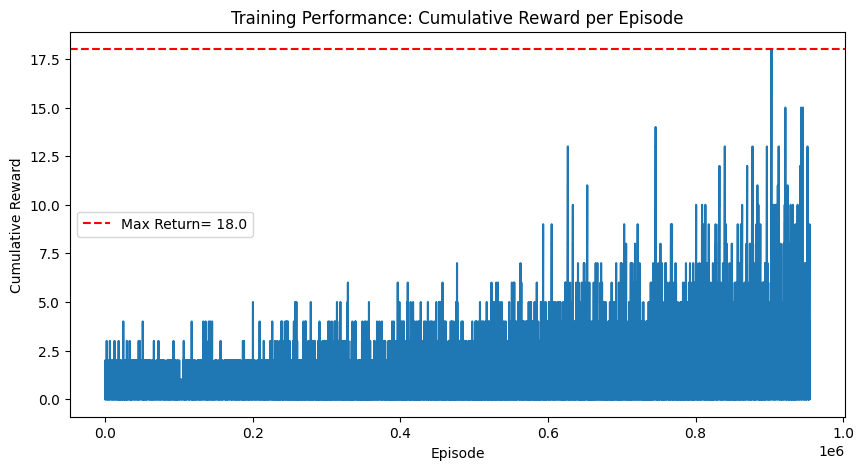

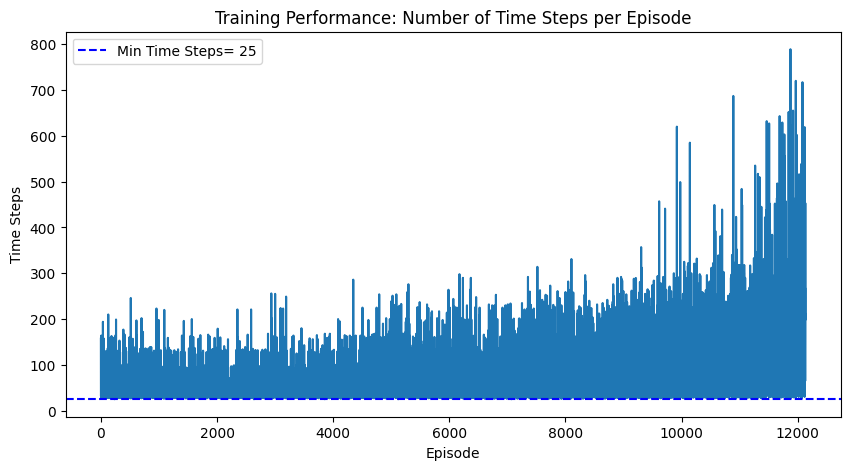

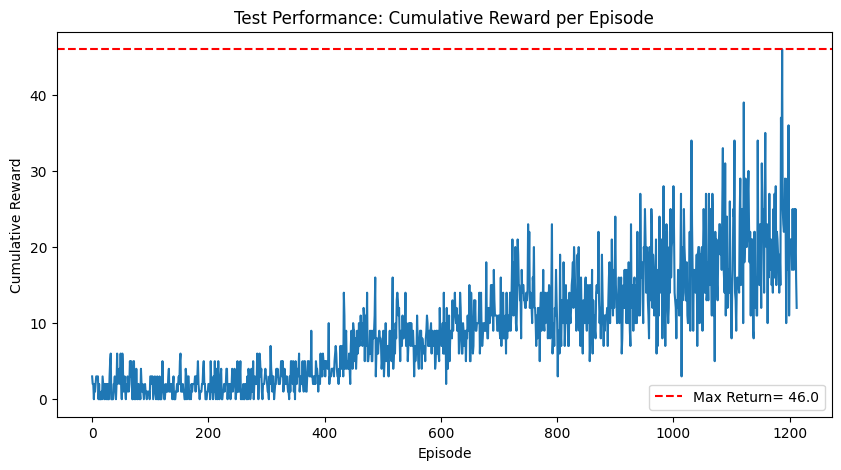

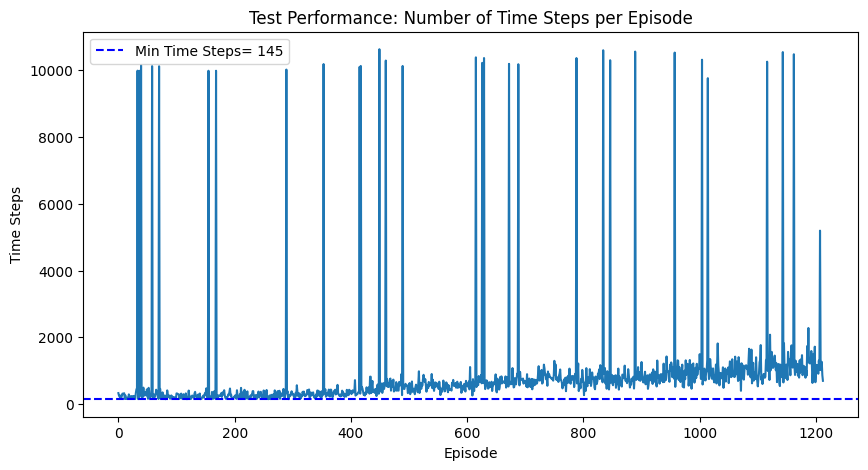

In [ ]:
# Plot cumulative reward per episode for training
plt.figure(figsize=(10, 5))
plt.plot(cumulative_rewards)
# plt.axvline(x=np.argmin(cumulative_rewards), color='r', linestyle='--', label='Optimal Episode')
plt.axhline(y=max(cumulative_rewards), color='r', linestyle='--', label=f'Max Return= {max(cumulative_rewards)}')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Training Performance: Cumulative Reward per Episode')
plt.legend()
plt.show()

# Plot number of time steps required per episode for training
plt.figure(figsize=(10, 5))
plt.plot(time_steps)
# plt.axvline(x=np.argmin(time_steps), color='r', linestyle='--', label='Optimal Episode')
plt.axhline(y=min(time_steps), color='b', linestyle='--', label=f'Min Time Steps= {min(time_steps)}')
plt.xlabel('Episode')
plt.ylabel('Time Steps')
plt.title('Training Performance: Number of Time Steps per Episode')
plt.legend()
plt.show()


# Plot cumulative reward per episode for test
plt.figure(figsize=(10, 5))
plt.plot(test_cumulative_rewards)
# plt.axvline(x=np.argmin(max_test_return), color='r', linestyle='--', label='Optimal Episode')
plt.axhline(y=max_test_return, color='r', linestyle='--', label=f'Max Return= {max_test_return}')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Test Performance: Cumulative Reward per Episode')
plt.legend()
plt.show()

# Plot number of time steps required per episode for test
plt.figure(figsize=(10, 5))
plt.plot(test_time_steps)
# plt.axvline(x=np.argmin(min_test_time_steps), color='r', linestyle='--', label='Optimal Episode')
plt.axhline(y=min_test_time_steps, color='b', linestyle='--', label=f'Min Time Steps= {min_test_time_steps}')
plt.xlabel('Episode')
plt.ylabel('Time Steps')
plt.title('Test Performance: Number of Time Steps per Episode')
plt.legend()
plt.show()

**Obseravtions:**

* Training Performance:
  * Maximum return: 18.0
  * Minimum number of time-steps: 25

* Test Performance:
  * Maximum return: 46.0
  * Minimum number of time-steps: 145

**5.2 Save and load the model**

In [ ]:
# #Saving the model
# model_name = 'breakout_model_10_trial_2'
# path = F"/content/gdrive/MyDrive/models/{model_name}"
# model.save(path)

# Loading the model
# model = tf.keras.models.load_model(path)

model_name = 'breakout_model_10_trial_2'
path = F"/content/gdrive/MyDrive/models/{model_name}"
model = tf.keras.models.load_model(path)

**6.2 Making videos of our agent play**

In [ ]:
def make_env():
  env = make_atari("BreakoutNoFrameskip-v4")
  env = wrap_deepmind(env, frame_stack=True, scale=True)
  return env

Lost one life after 169 timesteps
{'ale.lives': 4}


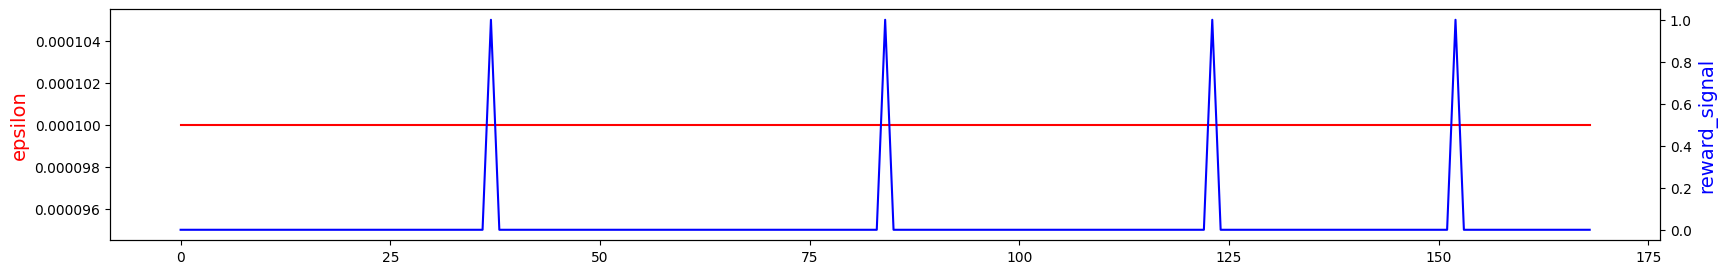

Bricks left to destroy  104.0
Lost one life after 321 timesteps
{'ale.lives': 3}


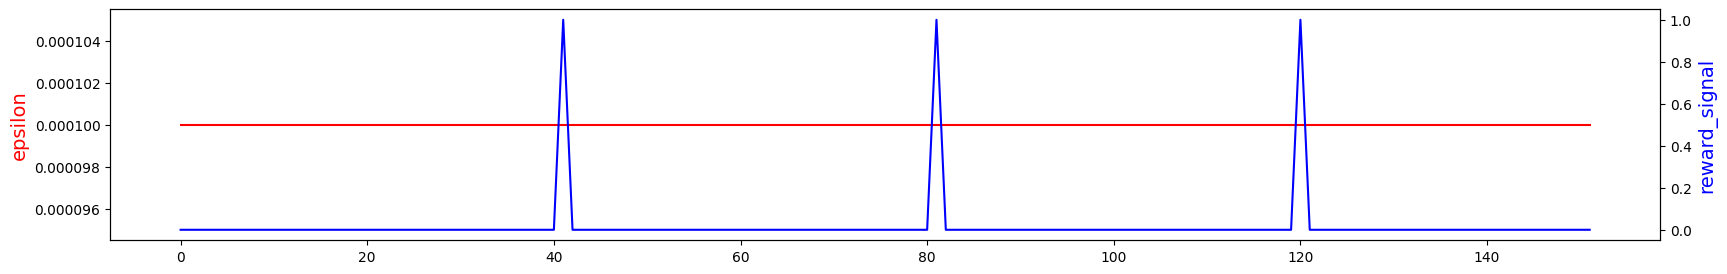

Bricks left to destroy  101.0
Lost one life after 500 timesteps
{'ale.lives': 2}


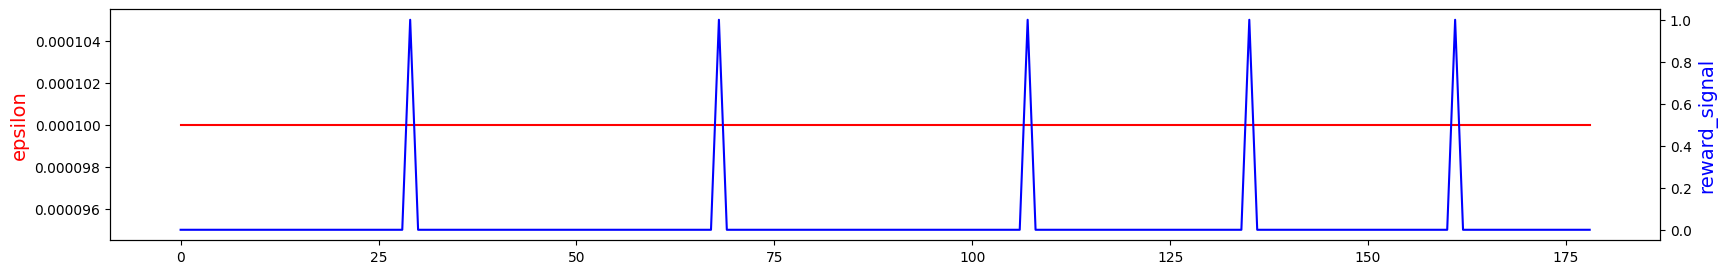

Bricks left to destroy  96.0
Lost one life after 670 timesteps
{'ale.lives': 1}


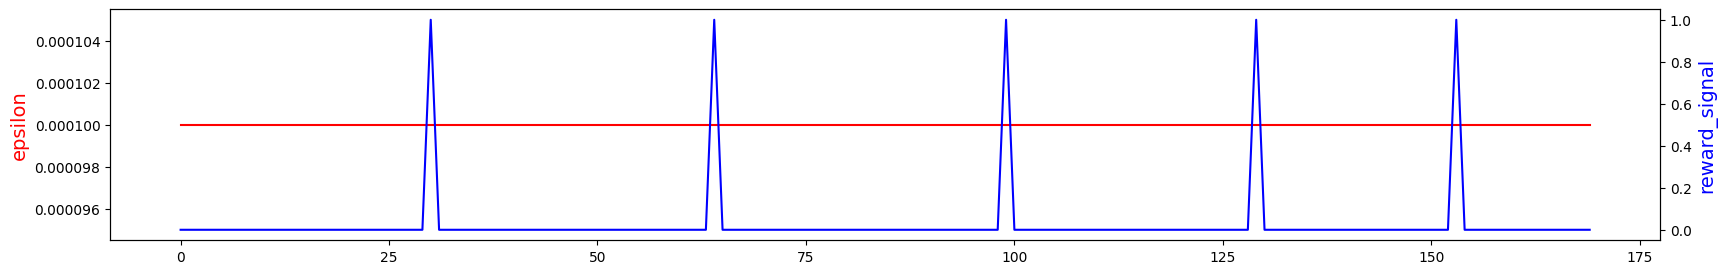

Bricks left to destroy  91.0
Lost one life after 742 timesteps
{'ale.lives': 0}


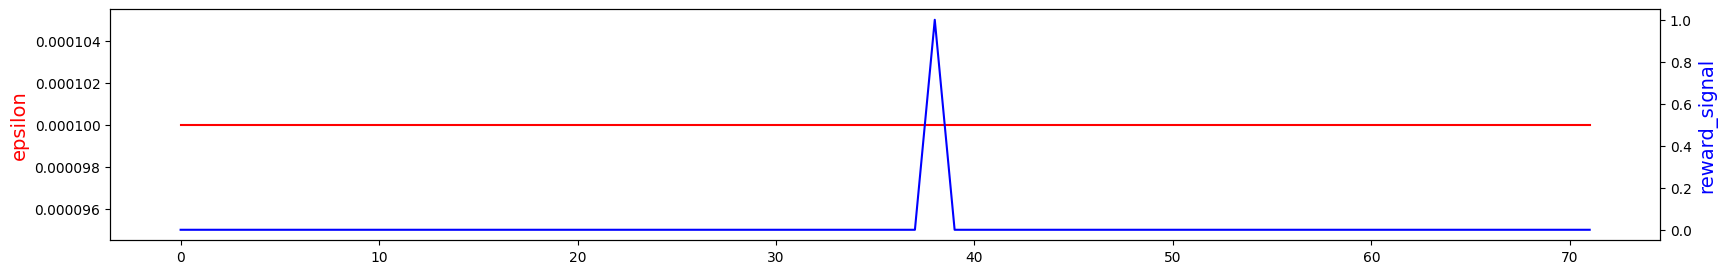

Bricks left to destroy  90.0


In [ ]:
env = make_env()
env = gym.wrappers.Monitor(env, "./vid1", force=True)

observation = env.reset()
info = 0
reward_window = []
reward_signal_history = []
epsilon_history = []

hits = []
bltd = 108 #total bricks to destroy

for i_episode in range(1):
    reward_window=[]
    epsilon = 0
    for t in range(4000):

        if epsilon > np.random.rand(1)[0]:
          action = np.random.choice(num_actions)
        else:
          state_tensor = tf.convert_to_tensor(observation)
          state_tensor = tf.expand_dims(state_tensor, 0)
          action_probs = model(state_tensor, training=False)
          action = tf.argmax(action_probs[0]).numpy()

        observation, reward, done, info = env.step(action)
        hits.append(reward)
        reward_window.append(reward)
        if len(reward_window) > 200:
          del reward_window[:1]
        if len(reward_window) == 200 and np.sum(reward_window) == 0:
          epsilon = 0.01
        else:
          epsilon = 0.0001

        epsilon_history.append(epsilon)
        reward_signal_history.append(reward)


        if done:
            print("Lost one life after {} timesteps".format(t+1))
            print(info)
            # Plot epsilon and reward signal
            fig,ax=plt.subplots(figsize=(20,3))
            #plt.clf()
            ax.plot(epsilon_history, color="red")
            ax.set_ylabel("epsilon",color="red",fontsize=14)
            ax2=ax.twinx()
            ax2.plot(reward_signal_history,color="blue")
            ax2.set_ylabel("reward_signal",color="blue",fontsize=14)
            plt.show()

            epsilon_history = []
            reward_signal_history = []

            bltd = bltd-np.sum(hits)
            hits = []
            print("Bricks left to destroy ", bltd)
            if info['ale.lives'] == 0:
              break

            env.reset()
env.close()

#Trial 3

In this trail, we focused also on tring different hyper parameters in order to find out the effect on the model performance and tring to improve it.

**4.3 Configuring the hyperparamaters and model training**

In [ ]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from collections import deque

# Setting epsilon decay parameters
epsilon = 1.0
epsilon_max_1 = 0.8
epsilon_min_1 = 0.05
epsilon_max_2 = epsilon_min_1
epsilon_min_2 = 0.01
epsilon_max_3 = epsilon_min_2
epsilon_min_3 = 0.01

epsilon_interval_1 = (epsilon_max_1 - epsilon_min_1)
epsilon_interval_2 = (epsilon_max_2 - epsilon_min_2)
epsilon_interval_3 = (epsilon_max_3 - epsilon_min_3)

# Number of frames for exploration
epsilon_greedy_frames = 1000000.0

# Number of frames to take random action and observe output
epsilon_random_frames = 50000

# Maximum Replay Buffer volume
max_memory_length = 200000

# Size of batch taken from replay buffer
batch_size = 64
max_steps_per_episode = 10000

# Train the model after 100 actions
update_after_actions = 100

# How often to update the target network
update_target_network = 5000

# Optimizer and loss function
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
loss_function = Huber()

In [ ]:
# Create the replay buffer using deque
max_memory_length = 20000
action_history = deque(maxlen=max_memory_length)
state_history = deque(maxlen=max_memory_length)
state_next_history = deque(maxlen=max_memory_length)
rewards_history = deque(maxlen=max_memory_length)
done_history = deque(maxlen=max_memory_length)

# Other parameters
batch_size = 64
gamma = 0.85
update_after_actions = 100
update_target_network = 5000

# Experience replay buffers
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

In this modified trail, the following changes were made:

1. Adjusted the epsilon decay parameters (epsilon_max_1, epsilon_min_1, epsilon_max_2, epsilon_min_2, epsilon_max_3, epsilon_min_3) to have lower maximum values and lower minimum values. This allows for a more gradual exploration-exploitation trade-off.

2. Increased the maximum replay buffer volume (max_memory_length) to 200,000 to store more experiences and improve learning.

3. Increased the batch size (batch_size) to 64 for more efficient training.

4. Set update_after_actions to 100, indicating that the model will start training after 100 actions instead of 20.

5. Changed update_target_network to 5000, specifying that the target network will be updated every 5000 frames.

6. Adjusted the learning rate in the optimizer (learning_rate) to 0.0001 for potentially better convergence.

7. Decreased gamma to 0.85


In [ ]:
# Optimized
cumulative_rewards = []
time_steps = []
test_cumulative_rewards = []
test_time_steps = []

max_test_return = float('-inf')
min_test_time_steps = float('inf')

while True:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            action = np.random.choice(num_actions)
        else:
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            action = tf.argmax(action_probs[0]).numpy()

        if frame_count < epsilon_greedy_frames:
            epsilon -= epsilon_interval_1 / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min_1)
        elif frame_count < 2 * epsilon_greedy_frames:
            epsilon -= epsilon_interval_2 / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min_2)
        else:
            epsilon -= epsilon_interval_3 / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min_3)

        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward
        cumulative_rewards.append(episode_reward)


        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
            indices = np.random.choice(len(done_history), size=batch_size, replace=False)
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = np.array([rewards_history[i] for i in indices])
            action_sample = np.array([action_history[i] for i in indices])
            done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])

            with tf.GradientTape() as tape:
                future_rewards = model_target(state_next_sample, training=False)
                updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards, axis=1)
                updated_q_values = updated_q_values * (1 - done_sample) - done_sample

                masks = tf.one_hot(action_sample, num_actions)
                q_values = model(state_sample)
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                loss = loss_function(updated_q_values, q_action)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Clear gradients and intermediate variables
            del tape, state_sample, state_next_sample, rewards_sample, action_sample, done_sample

        if frame_count % update_target_network == 0:
            model_target.set_weights(model.get_weights())
            template = "running reward: {:.2f} at episode {}, frame count {}, epsilon {:.3f}, loss {:.5f}"
            print(template.format(running_reward, episode_count, frame_count, epsilon, loss))

        if len(rewards_history) > max_memory_length:
            action_history.popleft()
            state_history.popleft()
            state_next_history.popleft()
            rewards_history.popleft()
            done_history.popleft()

        if done:
            break


    episode_reward_history.append(episode_reward)
    time_steps.append(timestep)

    if len(episode_reward_history) > 100:
        episode_reward_history.pop(0)
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 4:
        print("Solved at episode {}!".format(episode_count))
        break

    if episode_count % 1000 == 0:
        model_name = f'breakout_model_episode{episode_count}_trial_2'
        path = F"/content/gdrive/MyDrive/models/{model_name}"
        model.save(path)


    # Evaluate the test performance after every 10 episodes of training
    if episode_count % 10 == 0:
        test_rewards = []
        test_episode_reward = 0
        test_episode_time_steps = 0

        for _ in range(5):  # Run 5 test episodes
            state = np.array(env.reset())
            episode_reward = 0

            for _ in range(max_steps_per_episode):
                state_tensor = tf.convert_to_tensor(state)
                state_tensor = tf.expand_dims(state_tensor, 0)
                action_probs = model(state_tensor, training=False)
                action = tf.argmax(action_probs[0]).numpy()

                state, reward, done, _ = env.step(action)
                state = np.array(state)

                episode_reward += reward
                test_episode_reward += reward
                test_episode_time_steps += 1

                if done:
                    break

            test_rewards.append(episode_reward)

        # Calculate the cumulative test reward
        cumulative_test_reward = np.sum(test_rewards)

        test_cumulative_rewards.append(cumulative_test_reward)
        test_time_steps.append(test_episode_time_steps)

        max_test_return = max(max_test_return, cumulative_test_reward)
        min_test_time_steps = min(min_test_time_steps, test_episode_time_steps)

        print("Cumulative Test Reward after episode {}: {:.2f}".format(episode_count, cumulative_test_reward))

Cumulative Test Reward after episode 10: 0.00
Cumulative Test Reward after episode 20: 0.00
Cumulative Test Reward after episode 30: 2.00
Cumulative Test Reward after episode 40: 2.00
Cumulative Test Reward after episode 50: 0.00
Cumulative Test Reward after episode 60: 1.00
Cumulative Test Reward after episode 70: 0.00
Cumulative Test Reward after episode 80: 4.00
Cumulative Test Reward after episode 90: 2.00
Cumulative Test Reward after episode 100: 2.00
Cumulative Test Reward after episode 110: 3.00
running reward: 0.22 at episode 114, frame count 5000, epsilon 0.996, loss 0.01619
Cumulative Test Reward after episode 120: 2.00
Cumulative Test Reward after episode 130: 0.00
Cumulative Test Reward after episode 140: 0.00
Cumulative Test Reward after episode 150: 2.00
Cumulative Test Reward after episode 160: 4.00
Cumulative Test Reward after episode 170: 3.00
Cumulative Test Reward after episode 180: 3.00
Cumulative Test Reward after episode 190: 2.00
Cumulative Test Reward after epis

Cumulative Test Reward after episode 1000: 0.00
running reward: 0.18 at episode 1002, frame count 45000, epsilon 0.966, loss 0.02125
Cumulative Test Reward after episode 1010: 0.00
Cumulative Test Reward after episode 1020: 0.00
Cumulative Test Reward after episode 1030: 2.00
Cumulative Test Reward after episode 1040: 0.00
Cumulative Test Reward after episode 1050: 0.00
Cumulative Test Reward after episode 1060: 0.00
Cumulative Test Reward after episode 1070: 1.00
Cumulative Test Reward after episode 1080: 2.00
Cumulative Test Reward after episode 1090: 1.00
Cumulative Test Reward after episode 1100: 0.00
running reward: 0.37 at episode 1100, frame count 50000, epsilon 0.963, loss 0.00794
Cumulative Test Reward after episode 1110: 3.00
Cumulative Test Reward after episode 1120: 2.00
Cumulative Test Reward after episode 1130: 4.00
Cumulative Test Reward after episode 1140: 4.00
Cumulative Test Reward after episode 1150: 1.00
Cumulative Test Reward after episode 1160: 0.00
Cumulative Tes

Cumulative Test Reward after episode 2000: 2.00
Cumulative Test Reward after episode 2010: 5.00
Cumulative Test Reward after episode 2020: 2.00
running reward: 0.23 at episode 2024, frame count 90000, epsilon 0.933, loss 0.00635
Cumulative Test Reward after episode 2030: 0.00
Cumulative Test Reward after episode 2040: 3.00
Cumulative Test Reward after episode 2050: 0.00
Cumulative Test Reward after episode 2060: 4.00
Cumulative Test Reward after episode 2070: 0.00
Cumulative Test Reward after episode 2080: 3.00
Cumulative Test Reward after episode 2090: 0.00
Cumulative Test Reward after episode 2100: 2.00
Cumulative Test Reward after episode 2110: 0.00
Cumulative Test Reward after episode 2120: 2.00
Cumulative Test Reward after episode 2130: 3.00
Cumulative Test Reward after episode 2140: 3.00
Cumulative Test Reward after episode 2150: 2.00
running reward: 0.16 at episode 2150, frame count 95000, epsilon 0.929, loss 0.00934
Cumulative Test Reward after episode 2160: 2.00
Cumulative Tes

Cumulative Test Reward after episode 3000: 2.00
Cumulative Test Reward after episode 3010: 0.00
Cumulative Test Reward after episode 3020: 2.00
Cumulative Test Reward after episode 3030: 1.00
Cumulative Test Reward after episode 3040: 1.00
Cumulative Test Reward after episode 3050: 2.00
Cumulative Test Reward after episode 3060: 1.00
Cumulative Test Reward after episode 3070: 1.00
Cumulative Test Reward after episode 3080: 2.00
running reward: 0.31 at episode 3089, frame count 140000, epsilon 0.895, loss 0.02956
Cumulative Test Reward after episode 3090: 3.00
Cumulative Test Reward after episode 3100: 2.00
Cumulative Test Reward after episode 3110: 0.00
Cumulative Test Reward after episode 3120: 3.00
Cumulative Test Reward after episode 3130: 3.00
Cumulative Test Reward after episode 3140: 2.00
Cumulative Test Reward after episode 3150: 2.00
Cumulative Test Reward after episode 3160: 2.00
Cumulative Test Reward after episode 3170: 2.00
Cumulative Test Reward after episode 3180: 1.00
Cu

Cumulative Test Reward after episode 4000: 1.00
Cumulative Test Reward after episode 4010: 4.00
Cumulative Test Reward after episode 4020: 2.00
Cumulative Test Reward after episode 4030: 3.00
Cumulative Test Reward after episode 4040: 0.00
running reward: 0.31 at episode 4042, frame count 185000, epsilon 0.861, loss 0.01729
Cumulative Test Reward after episode 4050: 1.00
Cumulative Test Reward after episode 4060: 2.00
Cumulative Test Reward after episode 4070: 1.00
Cumulative Test Reward after episode 4080: 3.00
Cumulative Test Reward after episode 4090: 4.00
Cumulative Test Reward after episode 4100: 2.00
Cumulative Test Reward after episode 4110: 1.00
Cumulative Test Reward after episode 4120: 3.00
Cumulative Test Reward after episode 4130: 0.00
Cumulative Test Reward after episode 4140: 2.00
running reward: 0.37 at episode 4141, frame count 190000, epsilon 0.858, loss 0.01384
Cumulative Test Reward after episode 4150: 3.00
Cumulative Test Reward after episode 4160: 3.00
Cumulative T

Cumulative Test Reward after episode 5000: 3.00
Cumulative Test Reward after episode 5010: 5.00
Cumulative Test Reward after episode 5020: 0.00
Cumulative Test Reward after episode 5030: 2.00
running reward: 0.18 at episode 5032, frame count 230000, epsilon 0.828, loss 0.01145
Cumulative Test Reward after episode 5040: 0.00
Cumulative Test Reward after episode 5050: 1.00
Cumulative Test Reward after episode 5060: 0.00
Cumulative Test Reward after episode 5070: 0.00
Cumulative Test Reward after episode 5080: 3.00
Cumulative Test Reward after episode 5090: 0.00
Cumulative Test Reward after episode 5100: 3.00
Cumulative Test Reward after episode 5110: 4.00
Cumulative Test Reward after episode 5120: 2.00
Cumulative Test Reward after episode 5130: 3.00
Cumulative Test Reward after episode 5140: 0.00
running reward: 0.27 at episode 5141, frame count 235000, epsilon 0.824, loss 0.00606
Cumulative Test Reward after episode 5150: 0.00
Cumulative Test Reward after episode 5160: 1.00
Cumulative T

Cumulative Test Reward after episode 6000: 0.00
Cumulative Test Reward after episode 6010: 3.00
Cumulative Test Reward after episode 6020: 0.00
Cumulative Test Reward after episode 6030: 0.00
Cumulative Test Reward after episode 6040: 2.00
Cumulative Test Reward after episode 6050: 1.00
Cumulative Test Reward after episode 6060: 5.00
Cumulative Test Reward after episode 6070: 2.00
running reward: 0.43 at episode 6070, frame count 280000, epsilon 0.790, loss 0.01164
Cumulative Test Reward after episode 6080: 0.00
Cumulative Test Reward after episode 6090: 3.00
Cumulative Test Reward after episode 6100: 2.00
Cumulative Test Reward after episode 6110: 4.00
Cumulative Test Reward after episode 6120: 0.00
Cumulative Test Reward after episode 6130: 2.00
Cumulative Test Reward after episode 6140: 3.00
Cumulative Test Reward after episode 6150: 3.00
Cumulative Test Reward after episode 6160: 0.00
Cumulative Test Reward after episode 6170: 0.00
Cumulative Test Reward after episode 6180: 0.00
Cu

Cumulative Test Reward after episode 7000: 0.00
Cumulative Test Reward after episode 7010: 3.00
Cumulative Test Reward after episode 7020: 1.00
Cumulative Test Reward after episode 7030: 1.00
Cumulative Test Reward after episode 7040: 1.00
Cumulative Test Reward after episode 7050: 1.00
running reward: 0.28 at episode 7051, frame count 325000, epsilon 0.756, loss 0.00504
Cumulative Test Reward after episode 7060: 1.00
Cumulative Test Reward after episode 7070: 1.00
Cumulative Test Reward after episode 7080: 1.00
Cumulative Test Reward after episode 7090: 4.00
Cumulative Test Reward after episode 7100: 2.00
Cumulative Test Reward after episode 7110: 2.00
Cumulative Test Reward after episode 7120: 2.00
Cumulative Test Reward after episode 7130: 2.00
Cumulative Test Reward after episode 7140: 2.00
Cumulative Test Reward after episode 7150: 3.00
running reward: 0.29 at episode 7157, frame count 330000, epsilon 0.753, loss 0.01692
Cumulative Test Reward after episode 7160: 3.00
Cumulative T

Cumulative Test Reward after episode 8000: 4.00
Cumulative Test Reward after episode 8010: 3.00
Cumulative Test Reward after episode 8020: 2.00
Cumulative Test Reward after episode 8030: 2.00
Cumulative Test Reward after episode 8040: 4.00
Cumulative Test Reward after episode 8050: 5.00
Cumulative Test Reward after episode 8060: 4.00
running reward: 0.30 at episode 8060, frame count 375000, epsilon 0.719, loss 0.00483
Cumulative Test Reward after episode 8070: 3.00
Cumulative Test Reward after episode 8080: 3.00
Cumulative Test Reward after episode 8090: 2.00
Cumulative Test Reward after episode 8100: 0.00
Cumulative Test Reward after episode 8110: 0.00
Cumulative Test Reward after episode 8120: 1.00
Cumulative Test Reward after episode 8130: 1.00
Cumulative Test Reward after episode 8140: 2.00
Cumulative Test Reward after episode 8150: 0.00
running reward: 0.35 at episode 8158, frame count 380000, epsilon 0.715, loss 0.01432
Cumulative Test Reward after episode 8160: 1.00
Cumulative T

Cumulative Test Reward after episode 9000: 3.00
Cumulative Test Reward after episode 9010: 0.00
Cumulative Test Reward after episode 9020: 3.00
Cumulative Test Reward after episode 9030: 2.00
Cumulative Test Reward after episode 9040: 2.00
Cumulative Test Reward after episode 9050: 0.00
Cumulative Test Reward after episode 9060: 3.00
running reward: 0.44 at episode 9064, frame count 425000, epsilon 0.681, loss 0.00634
Cumulative Test Reward after episode 9070: 0.00
Cumulative Test Reward after episode 9080: 2.00
Cumulative Test Reward after episode 9090: 1.00
Cumulative Test Reward after episode 9100: 1.00
Cumulative Test Reward after episode 9110: 2.00
Cumulative Test Reward after episode 9120: 3.00
Cumulative Test Reward after episode 9130: 3.00
Cumulative Test Reward after episode 9140: 2.00
Cumulative Test Reward after episode 9150: 3.00
Cumulative Test Reward after episode 9160: 0.00
Cumulative Test Reward after episode 9170: 2.00
Cumulative Test Reward after episode 9180: 2.00
ru

Cumulative Test Reward after episode 10000: 2.00
Cumulative Test Reward after episode 10010: 1.00
Cumulative Test Reward after episode 10020: 0.00
Cumulative Test Reward after episode 10030: 0.00
running reward: 0.24 at episode 10033, frame count 470000, epsilon 0.648, loss 0.00900
Cumulative Test Reward after episode 10040: 1.00
Cumulative Test Reward after episode 10050: 1.00
Cumulative Test Reward after episode 10060: 0.00
Cumulative Test Reward after episode 10070: 1.00
Cumulative Test Reward after episode 10080: 1.00
Cumulative Test Reward after episode 10090: 1.00
Cumulative Test Reward after episode 10100: 1.00
Cumulative Test Reward after episode 10110: 2.00
Cumulative Test Reward after episode 10120: 2.00
Cumulative Test Reward after episode 10130: 2.00
running reward: 0.40 at episode 10133, frame count 475000, epsilon 0.644, loss 0.01014
Cumulative Test Reward after episode 10140: 2.00
Cumulative Test Reward after episode 10150: 3.00
Cumulative Test Reward after episode 10160

Cumulative Test Reward after episode 11000: 2.00
Cumulative Test Reward after episode 11010: 1.00
Cumulative Test Reward after episode 11020: 1.00
Cumulative Test Reward after episode 11030: 2.00
Cumulative Test Reward after episode 11040: 2.00
Cumulative Test Reward after episode 11050: 2.00
Cumulative Test Reward after episode 11060: 0.00
Cumulative Test Reward after episode 11070: 0.00
Cumulative Test Reward after episode 11080: 1.00
running reward: 0.27 at episode 11083, frame count 520000, epsilon 0.610, loss 0.00114
Cumulative Test Reward after episode 11090: 2.00
Cumulative Test Reward after episode 11100: 1.00
Cumulative Test Reward after episode 11110: 2.00
Cumulative Test Reward after episode 11120: 2.00
Cumulative Test Reward after episode 11130: 1.00
Cumulative Test Reward after episode 11140: 0.00
Cumulative Test Reward after episode 11150: 0.00
Cumulative Test Reward after episode 11160: 2.00
Cumulative Test Reward after episode 11170: 2.00
Cumulative Test Reward after ep

Cumulative Test Reward after episode 12000: 2.00
Cumulative Test Reward after episode 12010: 3.00
Cumulative Test Reward after episode 12020: 1.00
Cumulative Test Reward after episode 12030: 1.00
Cumulative Test Reward after episode 12040: 3.00
Cumulative Test Reward after episode 12050: 0.00
Cumulative Test Reward after episode 12060: 2.00
Cumulative Test Reward after episode 12070: 0.00
running reward: 0.28 at episode 12073, frame count 565000, epsilon 0.576, loss 0.00415
Cumulative Test Reward after episode 12080: 2.00
Cumulative Test Reward after episode 12090: 0.00
Cumulative Test Reward after episode 12100: 2.00
Cumulative Test Reward after episode 12110: 0.00
Cumulative Test Reward after episode 12120: 0.00
Cumulative Test Reward after episode 12130: 2.00
Cumulative Test Reward after episode 12140: 0.00
Cumulative Test Reward after episode 12150: 0.00
Cumulative Test Reward after episode 12160: 2.00
running reward: 0.42 at episode 12168, frame count 570000, epsilon 0.573, loss 0

Cumulative Test Reward after episode 13000: 4.00
Cumulative Test Reward after episode 13010: 4.00
running reward: 0.27 at episode 13013, frame count 610000, epsilon 0.543, loss 0.00842
Cumulative Test Reward after episode 13020: 4.00
Cumulative Test Reward after episode 13030: 1.00
Cumulative Test Reward after episode 13040: 1.00
Cumulative Test Reward after episode 13050: 1.00
Cumulative Test Reward after episode 13060: 1.00
Cumulative Test Reward after episode 13070: 1.00
Cumulative Test Reward after episode 13080: 3.00
Cumulative Test Reward after episode 13090: 1.00
Cumulative Test Reward after episode 13100: 0.00
Cumulative Test Reward after episode 13110: 3.00
Cumulative Test Reward after episode 13120: 3.00
running reward: 0.32 at episode 13120, frame count 615000, epsilon 0.539, loss 0.00635
Cumulative Test Reward after episode 13130: 3.00
Cumulative Test Reward after episode 13140: 4.00
Cumulative Test Reward after episode 13150: 2.00
Cumulative Test Reward after episode 13160

Cumulative Test Reward after episode 14000: 0.00
Cumulative Test Reward after episode 14010: 2.00
Cumulative Test Reward after episode 14020: 0.00
Cumulative Test Reward after episode 14030: 2.00
Cumulative Test Reward after episode 14040: 2.00
Cumulative Test Reward after episode 14050: 2.00
Cumulative Test Reward after episode 14060: 0.00
Cumulative Test Reward after episode 14070: 1.00
Cumulative Test Reward after episode 14080: 0.00
Cumulative Test Reward after episode 14090: 5.00
Cumulative Test Reward after episode 14100: 2.00
running reward: 0.37 at episode 14101, frame count 665000, epsilon 0.501, loss 0.01088
Cumulative Test Reward after episode 14110: 0.00
Cumulative Test Reward after episode 14120: 2.00
Cumulative Test Reward after episode 14130: 6.00
Cumulative Test Reward after episode 14140: 3.00
Cumulative Test Reward after episode 14150: 2.00
Cumulative Test Reward after episode 14160: 2.00
Cumulative Test Reward after episode 14170: 4.00
Cumulative Test Reward after ep

Cumulative Test Reward after episode 15000: 0.00
Cumulative Test Reward after episode 15010: 1.00
Cumulative Test Reward after episode 15020: 2.00
Cumulative Test Reward after episode 15030: 2.00
Cumulative Test Reward after episode 15040: 4.00
running reward: 0.28 at episode 15043, frame count 710000, epsilon 0.468, loss 0.00177
Cumulative Test Reward after episode 15050: 1.00
Cumulative Test Reward after episode 15060: 2.00
Cumulative Test Reward after episode 15070: 4.00
Cumulative Test Reward after episode 15080: 2.00
Cumulative Test Reward after episode 15090: 0.00
Cumulative Test Reward after episode 15100: 3.00
Cumulative Test Reward after episode 15110: 3.00
Cumulative Test Reward after episode 15120: 0.00
Cumulative Test Reward after episode 15130: 2.00
running reward: 0.48 at episode 15134, frame count 715000, epsilon 0.464, loss 0.01316
Cumulative Test Reward after episode 15140: 6.00
Cumulative Test Reward after episode 15150: 3.00
Cumulative Test Reward after episode 15160

Cumulative Test Reward after episode 16000: 0.00
Cumulative Test Reward after episode 16010: 1.00
Cumulative Test Reward after episode 16020: 1.00
Cumulative Test Reward after episode 16030: 4.00
Cumulative Test Reward after episode 16040: 0.00
Cumulative Test Reward after episode 16050: 0.00
Cumulative Test Reward after episode 16060: 2.00
running reward: 0.31 at episode 16069, frame count 760000, epsilon 0.430, loss 0.01289
Cumulative Test Reward after episode 16070: 2.00
Cumulative Test Reward after episode 16080: 3.00
Cumulative Test Reward after episode 16090: 0.00
Cumulative Test Reward after episode 16100: 1.00
Cumulative Test Reward after episode 16110: 3.00
Cumulative Test Reward after episode 16120: 4.00
Cumulative Test Reward after episode 16130: 0.00
Cumulative Test Reward after episode 16140: 2.00
Cumulative Test Reward after episode 16150: 1.00
Cumulative Test Reward after episode 16160: 0.00
running reward: 0.44 at episode 16160, frame count 765000, epsilon 0.426, loss 0

KeyboardInterrupt: ignored

**Observations:**

* The results display various metrics at regular intervals to track the agent's progress. One important metric is the running reward, which indicates the average reward obtained by the agent over a certain number of episodes. For example, at episode 114, the running reward was 0.22. This means that, on average, the agent received a reward of 0.22 per episode at that point in training.

* The frame count represents the total number of frames, or time steps, the agent has experienced during training. For instance, at episode 564, the frame count was 25000, indicating that the agent had gone through 25,000 time steps by that point. The frame count helps measure the amount of training the agent has undergone.


* The epsilon value is another crucial parameter that affects the agent's behavior. It represents the exploration-exploitation trade-off in the epsilon-greedy strategy. It starts at a high value (close to 1) and gradually decreases over time. At episode 114, the epsilon value was 0.996, implying that the agent was still exploring the environment more than exploiting its learned knowledge.

* The loss value indicates the value of the loss function, which is used to update the neural network parameters during training. At episode 114, the loss was 0.01619. Lower loss values generally indicate that the agent's neural network is better approximating the optimal action-value function.

* Despite the training progress, the agent was unable to solve the Breakout game and reach the target reward. This outcome suggests that the agent's performance did not meet the desired level of proficiency in playing the game.

* The training reached 16000 episodes but the agent didn't learn and the runtime got crashed!

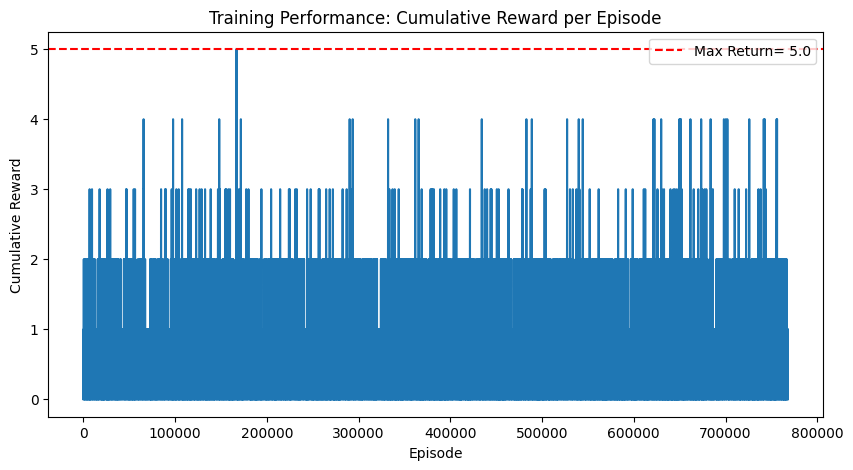

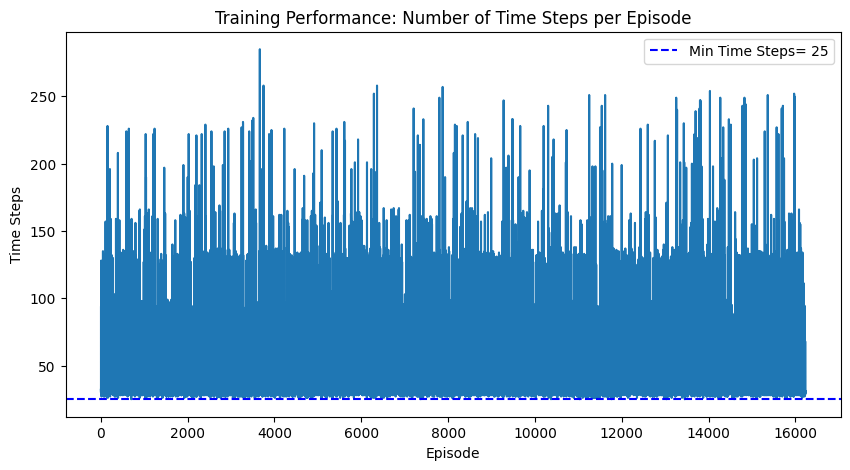

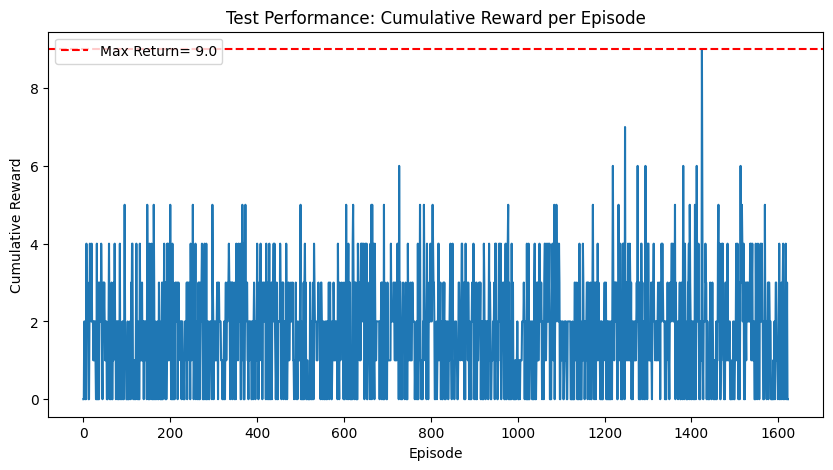

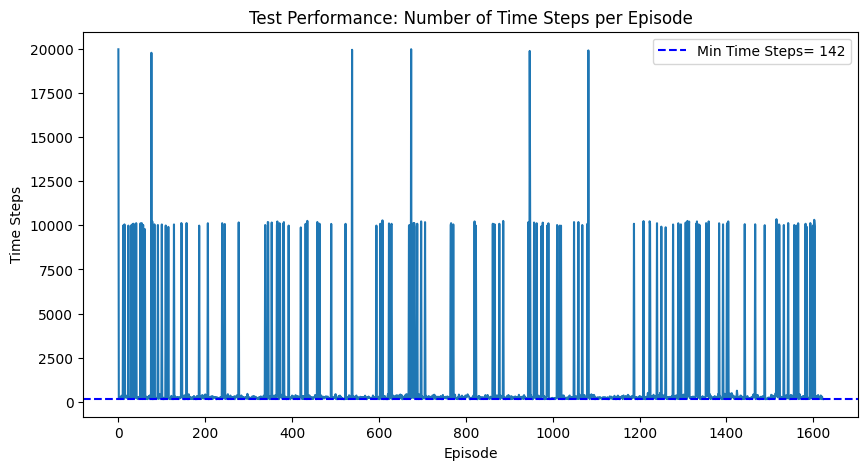

In [ ]:
# Plot cumulative reward per episode for training
plt.figure(figsize=(10, 5))
plt.plot(cumulative_rewards)
# plt.axvline(x=np.argmin(cumulative_rewards), color='r', linestyle='--', label='Optimal Episode')
plt.axhline(y=max(cumulative_rewards), color='r', linestyle='--', label=f'Max Return= {max(cumulative_rewards)}')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Training Performance: Cumulative Reward per Episode')
plt.legend()
plt.show()

# Plot number of time steps required per episode for training
plt.figure(figsize=(10, 5))
plt.plot(time_steps)
# plt.axvline(x=np.argmin(time_steps), color='r', linestyle='--', label='Optimal Episode')
plt.axhline(y=min(time_steps), color='b', linestyle='--', label=f'Min Time Steps= {min(time_steps)}')
plt.xlabel('Episode')
plt.ylabel('Time Steps')
plt.title('Training Performance: Number of Time Steps per Episode')
plt.legend()
plt.show()


# Plot cumulative reward per episode for test
plt.figure(figsize=(10, 5))
plt.plot(test_cumulative_rewards)
# plt.axvline(x=np.argmin(max_test_return), color='r', linestyle='--', label='Optimal Episode')
plt.axhline(y=max_test_return, color='r', linestyle='--', label=f'Max Return= {max_test_return}')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Test Performance: Cumulative Reward per Episode')
plt.legend()
plt.show()

# Plot number of time steps required per episode for test
plt.figure(figsize=(10, 5))
plt.plot(test_time_steps)
# plt.axvline(x=np.argmin(min_test_time_steps), color='r', linestyle='--', label='Optimal Episode')
plt.axhline(y=min_test_time_steps, color='b', linestyle='--', label=f'Min Time Steps= {min_test_time_steps}')
plt.xlabel('Episode')
plt.ylabel('Time Steps')
plt.title('Test Performance: Number of Time Steps per Episode')
plt.legend()
plt.show()

**Obseravtions:**

* Training Performance:
  * Maximum return: 5.0
  * Minimum number of time-steps: 25

* Test Performance:
  * Maximum return: 9.0
  * Minimum number of time-steps: 142

**5.3 Save and load the model**

In [ ]:
# #Saving the model
# model_name = 'breakout_model_10_trial_3'
# path = F"/content/gdrive/MyDrive/models/{model_name}"
# model.save(path)

# Loading the model
# model = tf.keras.models.load_model(path)

model_name = 'breakout_model_10_trial_3'
path = F"/content/gdrive/MyDrive/models/{model_name}"
model = tf.keras.models.load_model(path)

**6.3 Making videos of our agent play**

In [ ]:
def make_env():
  env = make_atari("BreakoutNoFrameskip-v4")
  env = wrap_deepmind(env, frame_stack=True, scale=True)
  return env

Lost one life after 51 timesteps
{'ale.lives': 4}


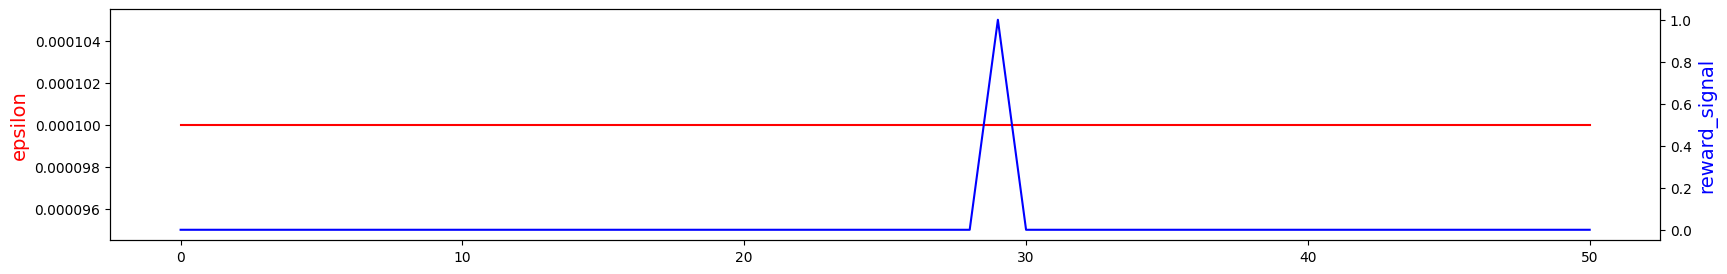

Bricks left to destroy  107.0
Lost one life after 72 timesteps
{'ale.lives': 3}


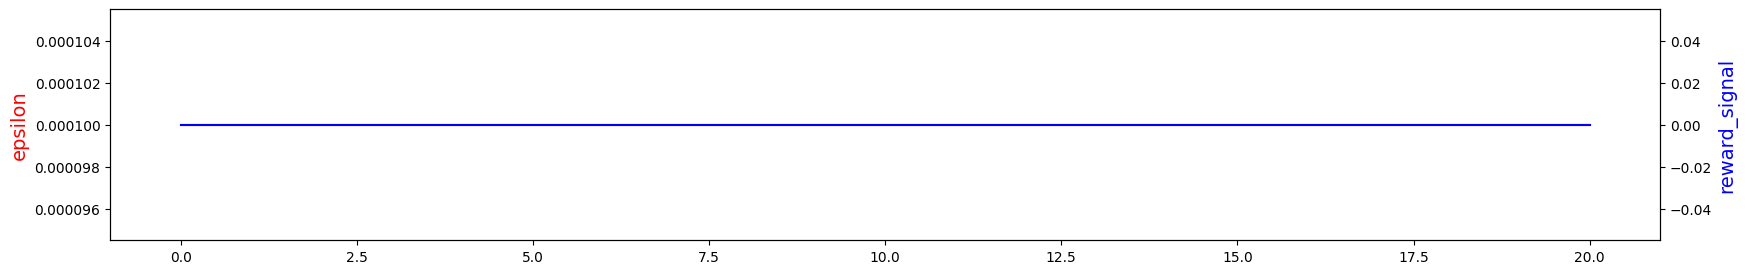

Bricks left to destroy  107.0
Lost one life after 125 timesteps
{'ale.lives': 2}


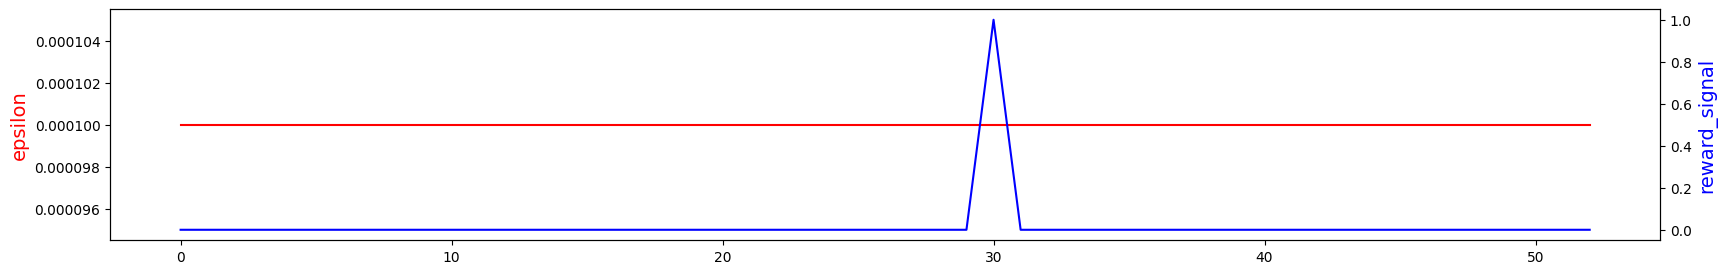

Bricks left to destroy  106.0
Lost one life after 179 timesteps
{'ale.lives': 1}


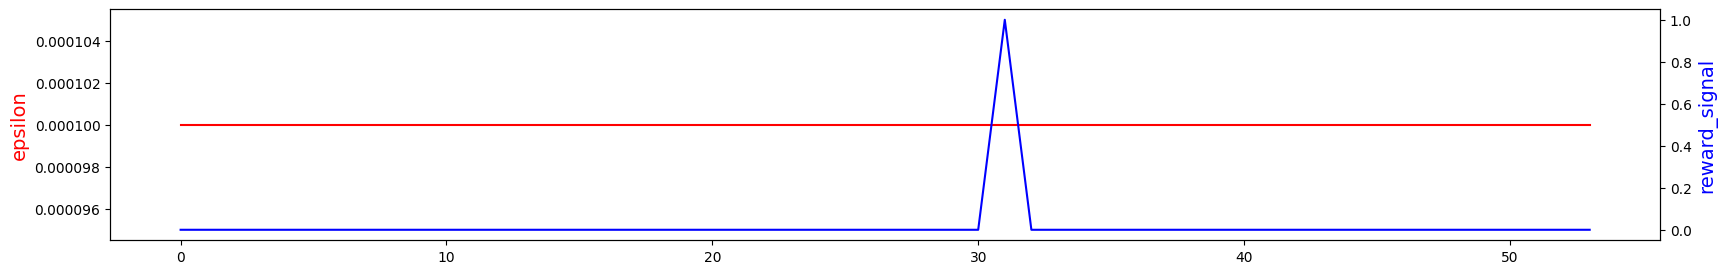

Bricks left to destroy  105.0
Lost one life after 234 timesteps
{'ale.lives': 0}


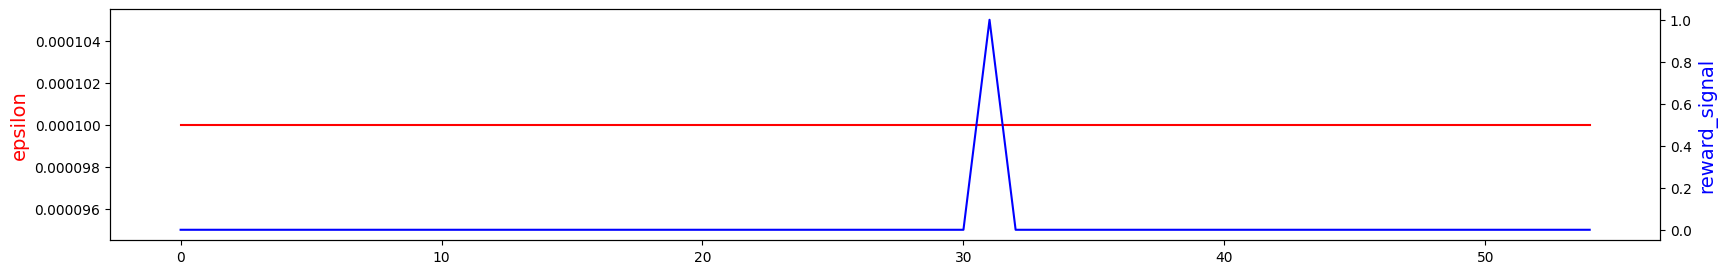

Bricks left to destroy  104.0


In [ ]:
env = make_env()
env = gym.wrappers.Monitor(env, "./vid1", force=True)

observation = env.reset()
info = 0
reward_window = []
reward_signal_history = []
epsilon_history = []

hits = []
bltd = 108 #total bricks to destroy

for i_episode in range(1):
    reward_window=[]
    epsilon = 0
    for t in range(4000):

        if epsilon > np.random.rand(1)[0]:
          action = np.random.choice(num_actions)
        else:
          state_tensor = tf.convert_to_tensor(observation)
          state_tensor = tf.expand_dims(state_tensor, 0)
          action_probs = model(state_tensor, training=False)
          action = tf.argmax(action_probs[0]).numpy()

        observation, reward, done, info = env.step(action)
        hits.append(reward)
        reward_window.append(reward)
        if len(reward_window) > 200:
          del reward_window[:1]
        if len(reward_window) == 200 and np.sum(reward_window) == 0:
          epsilon = 0.01
        else:
          epsilon = 0.0001

        epsilon_history.append(epsilon)
        reward_signal_history.append(reward)


        if done:
            print("Lost one life after {} timesteps".format(t+1))
            print(info)
            # Plot epsilon and reward signal
            fig,ax=plt.subplots(figsize=(20,3))
            #plt.clf()
            ax.plot(epsilon_history, color="red")
            ax.set_ylabel("epsilon",color="red",fontsize=14)
            ax2=ax.twinx()
            ax2.plot(reward_signal_history,color="blue")
            ax2.set_ylabel("reward_signal",color="blue",fontsize=14)
            plt.show()

            epsilon_history = []
            reward_signal_history = []

            bltd = bltd-np.sum(hits)
            hits = []
            print("Bricks left to destroy ", bltd)
            if info['ale.lives'] == 0:
              break

            env.reset()
env.close()